# Predicting Heart Failure

    age: Возраст пациента (int)
    anaemia: снижение эритроцитов или гемоглобина (boolean)
    high blood pressure: наличие артериальной гипертензии (boolean)
    creatinine phosphokinase (CPK): уровень фермента КФК в крови (mcg/L)
    diabetes: наличие сахарного диабета (boolean)
    ejection fraction: процент крови, покидающей сердце при каждом сокращении (percentage)
    platelets: тромбоциты в крови (kiloplatelets/mL)
    sex: женщина или мужчина (binary)
    serum creatinine: уровень сывороточного креатинина в крови (mg/dL)
    serum sodium: уровень сывороточного натрия в крови (mEq/L)
    smoking: курит больной или нет (boolean)
    time: последующий период (days)
    [target] death event: пациент умер в течение периода наблюдения (boolean)


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('Heart Failure Clinical Records.csv', na_values='?')

In [3]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [4]:
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [5]:

df = df.rename(columns={'DEATH_EVENT': 'target'})

df['target'].value_counts(dropna=False)

0    203
1     96
Name: target, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  target                    299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


We have five categorical variables: anaemia, diabetes, high_blood_pressure, sex, and smoking, and numerical variables being the rest

In [7]:
print(df['anaemia'].value_counts(dropna=False))
print(df['diabetes'].value_counts(dropna=False))
print(df['high_blood_pressure'].value_counts(dropna=False))
print(df['sex'].value_counts(dropna=False))
print(df['smoking'].value_counts(dropna=False))

0    170
1    129
Name: anaemia, dtype: int64
0    174
1    125
Name: diabetes, dtype: int64
0    194
1    105
Name: high_blood_pressure, dtype: int64
1    194
0    105
Name: sex, dtype: int64
0    203
1     96
Name: smoking, dtype: int64


In [8]:
numeric_cols = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
cat_cols = list(set(df.columns) - set(numeric_cols) - {'target'} - {'time'})
cat_cols.sort()

print(numeric_cols)
print(cat_cols)

['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']


In [9]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   anaemia              299 non-null    int64
 1   diabetes             299 non-null    int64
 2   high_blood_pressure  299 non-null    int64
 3   sex                  299 non-null    int64
 4   smoking              299 non-null    int64
dtypes: int64(5)
memory usage: 11.8 KB


In [10]:
df = df[list(set(cat_cols) | set(numeric_cols) | {'target'})]
print(df['target'])

0      1
1      1
2      1
3      1
4      1
      ..
294    0
295    0
296    0
297    0
298    0
Name: target, Length: 299, dtype: int64


In [11]:
random_seed = 888
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed, stratify=df['target'])


print(df_train.shape)
print(df_test.shape)
print()
print(df_train['target'].value_counts(normalize=True))
print()
print(df_test['target'].value_counts(normalize=True))

(239, 12)
(60, 12)

0    0.677824
1    0.322176
Name: target, dtype: float64

0    0.683333
1    0.316667
Name: target, dtype: float64


In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer
    
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median"))
    ])

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

cat_pipeline = Pipeline([
        ('imputer',DataFrameImputer()),
        ('one-hot',OneHotEncoder(handle_unknown='ignore',drop='first'))])



In [13]:
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numeric_cols),
        ("cat", cat_pipeline, cat_cols),
    ])

y_train = df_train['target']
X_train = full_pipeline.fit_transform(df_train.drop(['target'], axis=1))

y_test = df_test['target']
X_test = full_pipeline.transform(df_test.drop(['target'], axis=1))


# LogisticRegression

In [14]:
regress_grid = [{
    'solver': ['saga', 'newton-cg', 'lbfgs', 'liblinear'],
    #'solver': ['saga', 'liblinear'],
    'penalty': ['l1', 'l2'],
    'C': np.arange(start = 0.001, stop = 2.001, step = 0.1),
    'tol': [1e-3],
    'multi_class': ['ovr'],
    'fit_intercept': [True, False],
    'random_state': [71],
    'max_iter': [5000]
}]
#logistic_regression = LogisticRegression(penalty='none', fit_intercept=True)
logistic_regression = GridSearchCV(estimator=LogisticRegression(), param_grid=regress_grid, cv=3, n_jobs=None, verbose=3)
logistic_regression.fit(X_train, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits
[CV 1/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 2/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 3/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=saga, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=newton-cg, tol=0.001;, score=nan total time=   0.0s
[CV 2/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=newton-cg, tol=0.001;, score=nan total time=   0.0s
[CV 3/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=newton-cg, tol=0.001;, sco

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.738 total time=   0.0s
[CV 2/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=0.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.001, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=0.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.722 total time=   0.0s
[CV 1/3] END C=0.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.101, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=0.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s
[CV 3/3] END C=0.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=0.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.101, 

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 1/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.722 total time=   0.0s
[CV 1/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s


The line search algorithm did not converge
The line search algorithm did not converge


[CV 2/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.850 total time=   0.0s
[CV 3/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=0.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 2/3] END C=0.201, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge


[CV 2/3] END C=0.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.201, 

The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 1/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s


The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 3/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=0.30100000000000005, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.30100000000000005, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 2/3] END C=0.30100000000000005, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, 

Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 2/3] END C=0.30100000000000005, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.30100000000000005, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.30100000000000005, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.30100000000000005, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.30100000000000005, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.30100000000000005, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71,

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 1/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s
[CV 2/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s


The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=0.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.401, fit_in

Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 1/3] END C=0.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.762 total time=   0.0s
[CV 2/3] END C=0.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=0.401, 

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=0.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.501, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 1/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 2/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 3/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 2/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=0.501, fit

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 2/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=0.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 2/3] EN

The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s
[CV 2/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s


Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 3/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.6010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=libl

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed


[CV 2/3] END C=0.6010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.6010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.6010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.6010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.6010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.6010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solve

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=0.7010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.7010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s


Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 3/3] END C=0.7010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.7010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.7010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.7010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.7010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.7010000000000001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=libl

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge


[CV 2/3] END C=0.7010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.7010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=0.7010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.7010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.7010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.7010000000000001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solve

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 3/3] END C=0.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=0.801, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=0.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=0.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.801, 

The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s
[CV 3/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.684 total time=   0.0s


Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=0.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=0.901, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=0.901, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 3/3] END C=0.901, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=0.901, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.901, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=0.901, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=0.901, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=0.901, 

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=1.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=1.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s


The line search algorithm did not converge
The line search algorithm did not converge


[CV 3/3] END C=1.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.001, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.001, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed


[CV 2/3] END C=1.001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 3/3] END C=1.001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.001, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.001, 

The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=1.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=1.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s


Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 3/3] END C=1.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.101, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.101, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=1.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 3/3] END C=1.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.850 total time=   0.0s
[CV 3/3] END C=1.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.101, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.101, 

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 1/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s
[CV 3/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s


The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 3/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.201, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=1.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 2/3] END C=1.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l1, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 3/3] END C=1.201, fit_in

Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge


[CV 2/3] END C=1.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s
[CV 3/3] END C=1.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.201, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.201, 

The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.750 total time=   0.0s
[CV 3/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s


Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.301, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=1.301, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=1.301, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s
[CV 3/3] END C=1.301, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.722 total time=   0.0s
[CV 1/3] END C=1.301, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.301, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.301, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.301, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.301, 

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=1.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.725 total time=   0.0s
[CV 3/3] END C=1.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.401, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.401, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 3/3] END C=1.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.722 total time=   0.0s
[CV 1/3] END C=1.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=1.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.401, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.401, 

The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 1/3] END C=1.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=1.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.725 total time=   0.0s


The line search algorithm did not converge
The line search algorithm did not converge


[CV 3/3] END C=1.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.1s
[CV 1/3] END C=1.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.501, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.501, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed


[CV 1/3] END C=1.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 2/3] END C=1.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s
[CV 3/3] END C=1.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.501, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.501, 

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=1.601, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.725 total time=   0.0s
[CV 3/3] END C=1.601, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.601, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.601, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.601, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.601, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.601, fit_in

The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 2/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 3/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 2/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s


The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed


[CV 3/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.601, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.601, 

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=1.701, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=1.701, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.725 total time=   0.0s


Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 3/3] END C=1.701, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.701, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.701, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.701, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.701, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.701, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.701, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 2/3] END C=1.701, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s
[CV 3/3] END C=1.701, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.701, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.701, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.701, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.701, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.701, 

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 2/3] END C=1.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.725 total time=   0.0s
[CV 3/3] END C=1.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.801, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.801, fit_in

The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 2/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.675 total time=   0.0s
[CV 3/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=saga, tol=0.001;, score=0.684 total time=   0.0s
[CV 1/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.775 total time=   0.0s
[CV 2/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.787 total time=   0.0s


The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge


[CV 3/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.801, fit_intercept=False, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.801, 

The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge
The line search algorithm did not converge


[CV 1/3] END C=1.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/3] END C=1.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.725 total time=   0.0s


Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed


[CV 3/3] END C=1.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=newton-cg, tol=0.001;, score=0.709 total time=   0.0s
[CV 1/3] END C=1.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.762 total time=   0.0s
[CV 3/3] END C=1.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=lbfgs, tol=0.001;, score=0.696 total time=   0.0s
[CV 1/3] END C=1.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.688 total time=   0.0s
[CV 2/3] END C=1.901, fit_intercept=True, max_iter=5000, multi_class=ovr, penalty=l2, random_state=71, solver=liblinear, tol=0.001;, score=0.637 total time=   0.0s
[CV 3/3] END C=1.901, fit_in

The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Rounding errors prevent the line search from converging
Line Search failed
The line search algorithm did not converge
The line search algorithm did not converge
Line Search failed

240 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mrdar\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, 

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
       6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
       1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
       1.801e+00, 1.901e+00]),
                          'fit_intercept': [True, False], 'max_iter': [5000],
                          'multi_class': ['ovr'], 'penalty': ['l1', 'l2'],
                          'random_state': [71],
                          'solver': ['saga', 'newton-cg', 'lbfgs', 'liblinear'],
                          'tol': [0.001]}],
             verbose=3)

In [15]:
print(logistic_regression.best_estimator_)

LogisticRegression(C=1.301, max_iter=5000, multi_class='ovr', penalty='l1',
                   random_state=71, solver='liblinear', tol=0.001)


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


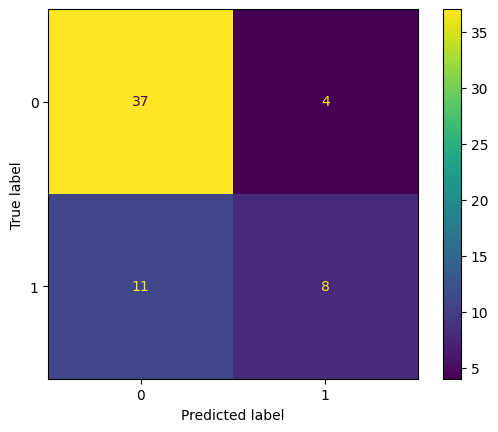

In [16]:
plot_confusion_matrix(logistic_regression.best_estimator_, X_test, y_test)
#plot_roc_curve(logistic_regression, X_test, y_test)
#plot_precision_recall_curve(logistic_regression, X_test, y_test)

In [17]:
test_prob = logistic_regression.predict_proba(X_test)[:, 1]
test_pred = logistic_regression.predict(X_test)

In [18]:
threshold = 0.5
lr_test_pred = np.where(logistic_regression.predict_proba(X_test)[:,1] > threshold, 1, 0)

lr_score = logistic_regression.score(X_test, y_test)
lr_precision = precision_score(y_test, lr_test_pred)
lr_recall = recall_score(y_test, lr_test_pred)
lr_f1_score = f1_score(y_test, lr_test_pred)
lr_roc_auc = roc_auc_score(y_test, test_prob)

print('Score = {:.5f}'.format(lr_score))
print('Precision = {:.5f}'.format(lr_precision))
print('Recall = {:.5f}'.format(lr_recall))
print('F1 score = {:.5f}'.format(lr_f1_score))
print('AUC = {:.5f}'.format(lr_roc_auc))
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))

Score = 0.75000
Precision = 0.66667
Recall = 0.42105
F1 score = 0.51613
AUC = 0.65340
Log loss = 0.67249
Average Precision = 0.53912
Accuracy = 0.75000


# RandomForest

In [61]:
# forest_grid = [{
#     'n_estimators':      np.linspace(start = 100, stop = 1000, num = 5, dtype=int),
#     'max_features':      ['log2', 'sqrt'],
#     'max_depth':         np.linspace(start = 1, stop = 10, num = 4, dtype=int),
#     'min_samples_split': np.linspace(start = 2, stop = 50, num = 4, dtype=int),
#     'min_samples_leaf':  np.linspace(start = 2, stop = 50, num = 4, dtype=int),
#     'bootstrap':         [True, False]
# }]
forest_grid = [{
    'n_estimators':      np.linspace(start = 100, stop = 1000, num = 2, dtype=int),
    'max_features':      ['log2', 'sqrt'],
    'max_depth':         np.linspace(start = 1, stop = 10, num = 2, dtype=int),
    'min_samples_split': np.linspace(start = 2, stop = 50, num = 2, dtype=int),
    'min_samples_leaf':  np.linspace(start = 2, stop = 50, num = 2, dtype=int),
    'bootstrap':         [True, False]
}]
random_forest_classifier = GridSearchCV(estimator=RandomForestClassifier(random_state=71), param_grid=forest_grid, cv=3, verbose=3)
random_forest_classifier.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.700 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.725 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.696 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=0.713 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=0.713 total time=   2.6s
[CV 3/3] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=0.684 total time=   2.5s
[CV 1/3] END bootstrap=

[CV 3/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=0.671 total time=   2.6s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=0.725 total time=   0.2s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=0.812 total time=   0.2s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=0.671 total time=   0.2s
[CV 1/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=50, n_estimators=1000;, score=0.725 total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=50, n_estimators=1000;, score=0.775 total time=   2.5s
[CV 3/3] END bootstrap=True, max_depth=10, max_features=log2, min_samples_

[CV 3/3] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=50, n_estimators=1000;, score=0.684 total time=   1.8s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=100;, score=0.675 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=100;, score=0.675 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=100;, score=0.684 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=1000;, score=0.675 total time=   1.8s
[CV 2/3] END bootstrap=False, max_depth=1, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=1000;, score=0.675 total time=   1.8s
[CV 3/3] END bootstrap=False, max_depth=1, max_features=log2, min_samples

[CV 2/3] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=1000;, score=0.675 total time=   1.8s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=2, n_estimators=1000;, score=0.684 total time=   1.8s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=50, n_estimators=100;, score=0.675 total time=   0.1s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=50, n_estimators=100;, score=0.675 total time=   0.1s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=50, n_estimators=100;, score=0.722 total time=   0.1s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=50, min_samples_split=50, n_estimators=1000;, score=0.675 total time=   1.8s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=log2, 

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=71),
             param_grid=[{'bootstrap': [True, False],
                          'max_depth': array([ 1, 10]),
                          'max_features': ['log2', 'sqrt'],
                          'min_samples_leaf': array([ 2, 50]),
                          'min_samples_split': array([ 2, 50]),
                          'n_estimators': array([ 100, 1000])}],
             verbose=3)

In [62]:
print(random_forest_classifier.best_estimator_)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=2, random_state=71)


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


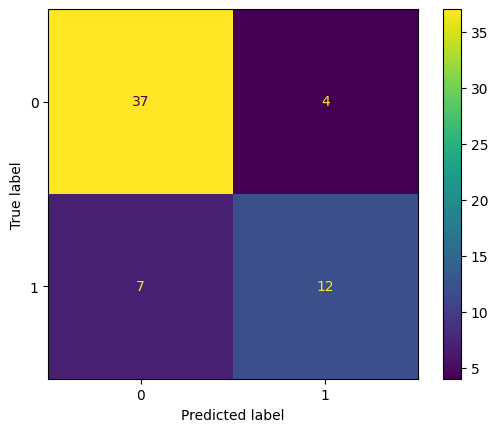

In [63]:
plot_confusion_matrix(random_forest_classifier.best_estimator_, X_test, y_test)
#plot_roc_curve(random_forest_classifier, X_test, y_test)
#plot_precision_recall_curve(random_forest_classifier, X_test, y_test)

In [64]:
rf_test_pred = np.where(random_forest_classifier.predict_proba(X_test)[:,1] > threshold, 1, 0)

rf_score = random_forest_classifier.score(X_test, y_test)
rf_precision = precision_score(y_test, rf_test_pred)
rf_recall = recall_score(y_test, rf_test_pred)
rf_f1_score = f1_score(y_test, rf_test_pred)
rf_roc_auc = roc_auc_score(y_test, rf_test_pred)

print('Score = {:.5f}'.format(rf_score))
print('Precision = {:.5f}'.format(rf_precision))
print('Recall = {:.5f}'.format(rf_recall))
print('F1 score = {:.5f}'.format(rf_f1_score))
print('AUC = {:.5f}'.format(rf_roc_auc))

Score = 0.81667
Precision = 0.75000
Recall = 0.63158
F1 score = 0.68571
AUC = 0.76701


# XGBClassifier

In [52]:
# xgb_classifier = XGBClassifier(random_state=71)
# xgb_classifier.fit(X_train, y_train)

xgb_grid = [{
    'min_child_weight':  np.arange(start = 1, stop = 8, step = 2, dtype=int),
    'gamma':             np.arange(start = 1, stop = 5, step = 0.5),
    'subsample':         np.arange(start = 0.8, stop = 1, step = 0.1),
    'colsample_bytree':  np.arange(start = 0.3, stop = 0.8, step = 0.2),
    'max_depth':         np.arange(start = 5, stop = 16, step = 2, dtype=int),
    'random_state':      [71]
}]
# xgb_grid = [{
#     'min_child_weight':  np.arange(start = 5, stop = 8, step = 1, dtype=int),
#     'gamma':             np.arange(start = 2, stop = 3, step = 0.5),
#     'subsample':         np.arange(start = 0.8, stop = 1, step = 0.1),
#     'colsample_bytree':  np.arange(start = 0.7, stop = 0.8, step = 0.1),
#     'max_depth':         np.arange(start = 9, stop = 10, step = 1, dtype=int),
#     'random_state':      [71]
# }]
# 
xgb_classifier = GridSearchCV(estimator=XGBClassifier(random_state=71), param_grid=xgb_grid, cv=3, verbose=3)
xgb_classifier.fit(X_train, y_train)


Fitting 3 folds for each of 1152 candidates, totalling 3456 fits
[CV 1/3] END colsample_bytree=0.3, gamma=1.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.787 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.0, max_depth=5, min_child_weight=3

[CV 2/3] END colsample_bytree=0.3, gamma=1.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.0, max_depth=9, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.0, max_depth=9, min_child_weight=7, random_state=71, subsample=0.8;, score=0.725 total time=   0.0s

[CV 3/3] END colsample_bytree=0.3, gamma=1.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.713 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.0, max_depth=15, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.0, max_depth=15, min_child_weight=3, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.0, max_depth=15, min_child_weight=3, random_state=71, subsample=0.8;, score=0.658 total time=

[CV 2/3] END colsample_bytree=0.3, gamma=1.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.713 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.9;, score=0.713 total time=   0.0s

[CV 3/3] END colsample_bytree=0.3, gamma=1.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.8;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=1.5, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=1.5, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=1.5, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.671 total time=

[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.9;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.0, max_depth=5, min_child_weight=7, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=5, min_child_weight=7, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s

[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.8;, score=0.688 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.0, max_depth=11, min_child_weight=3, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=11, min_child_weight=3, random_state=71, subsample=0.8;, score=0.775 total time=

[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=15, min_child_weight=3, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.0, max_depth=15, min_child_weight=3, random_state=71, subsample=0.9;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=

[CV 3/3] END colsample_bytree=0.3, gamma=2.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.9;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.696 total time=   0.0s

[CV 3/3] END colsample_bytree=0.3, gamma=2.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=2.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=2.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=2.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.658 total time=

[CV 1/3] END colsample_bytree=0.3, gamma=3.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.713 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.0, max_depth=7, min_child_weight=3, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.0, max_depth=7, min_child_weight=3, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.0, max_depth=7, min_child_weight=3, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.0, max_depth=7, min_child_weight=3, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s

[CV 1/3] END colsample_bytree=0.3, gamma=3.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.696 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.0, max_depth=13, min_child_weight=1, random_state=71, subsample=0.8;, score=0.762 total time=

[CV 2/3] END colsample_bytree=0.3, gamma=3.5, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.5, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.8;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s

[CV 1/3] END colsample_bytree=0.3, gamma=3.5, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.5, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.5, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s

[CV 1/3] END colsample_bytree=0.3, gamma=3.5, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.5, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.5, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.5, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=3.5, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=3.5, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=3.5, max_depth=15, min_child_weight=3, random_state=71, subsample=0.8;, score=0.750 total time=

[CV 3/3] END colsample_bytree=0.3, gamma=4.0, max_depth=7, min_child_weight=5, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.0, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.0, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.0, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.684 total time=   0.0s

[CV 3/3] END colsample_bytree=0.3, gamma=4.0, max_depth=13, min_child_weight=1, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.0, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.0, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.0, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.684 total time=

[CV 2/3] END colsample_bytree=0.3, gamma=4.5, max_depth=5, min_child_weight=5, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.5, max_depth=5, min_child_weight=5, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.5, max_depth=5, min_child_weight=5, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.5, max_depth=5, min_child_weight=5, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.5, max_depth=5, min_child_weight=5, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.5, max_depth=5, min_child_weight=7, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.5, max_depth=5, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s

[CV 3/3] END colsample_bytree=0.3, gamma=4.5, max_depth=11, min_child_weight=1, random_state=71, subsample=0.8;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.5, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.700 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.5, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.5, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.8;, score=0.684 total time=

[CV 1/3] END colsample_bytree=0.3, gamma=4.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.3, gamma=4.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 3/3] END colsample_bytree=0.3, gamma=4.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.3, gamma=4.5, max_depth=15, min_child_weight=7, random_state=71, subsample=0.8;, score=0.775 total time=

[CV 2/3] END colsample_bytree=0.5, gamma=1.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=1.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.608 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=1.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=1.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=1.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=1.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=1.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s

[CV 1/3] END colsample_bytree=0.5, gamma=1.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=1.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.8;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=1.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.8;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=1.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=1.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=1.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=1.0, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.787 total time=

[CV 3/3] END colsample_bytree=0.5, gamma=1.5, max_depth=5, min_child_weight=7, random_state=71, subsample=0.9;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=1.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=1.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=1.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.620 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=1.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=1.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=1.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s

[CV 2/3] END colsample_bytree=0.5, gamma=1.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.700 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=1.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=1.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=1.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.713 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=1.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=1.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.9;, score=0.812 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=1.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.9;, score=0.738 total time=

[CV 3/3] END colsample_bytree=0.5, gamma=1.5, max_depth=15, min_child_weight=7, random_state=71, subsample=0.9;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.713 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.620 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.671 total time=   0.0

[CV 1/3] END colsample_bytree=0.5, gamma=2.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.608 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s

[CV 2/3] END colsample_bytree=0.5, gamma=2.0, max_depth=13, min_child_weight=7, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.0, max_depth=13, min_child_weight=7, random_state=71, subsample=0.9;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.713 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.700 total time=

[CV 2/3] END colsample_bytree=0.5, gamma=2.5, max_depth=7, min_child_weight=3, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.5, max_depth=7, min_child_weight=3, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.8;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s

[CV 1/3] END colsample_bytree=0.5, gamma=2.5, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.5, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.5, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=2.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=2.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.8;, score=0.633 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=2.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.750 total time=

[CV 2/3] END colsample_bytree=0.5, gamma=3.0, max_depth=5, min_child_weight=3, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.0, max_depth=5, min_child_weight=3, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.8;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.0, max_depth=5, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s

[CV 3/3] END colsample_bytree=0.5, gamma=3.0, max_depth=9, min_child_weight=7, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.8;, score=0.812 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.8;, score=0.620 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.688 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.0, max_depth=11, min_child_weight=1, random_state=71, subsample=0.9;, score=0.633 total time= 

[CV 2/3] END colsample_bytree=0.5, gamma=3.0, max_depth=15, min_child_weight=3, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.0, max_depth=15, min_child_weight=3, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.0, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=

[CV 1/3] END colsample_bytree=0.5, gamma=3.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.5, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.5, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s

[CV 1/3] END colsample_bytree=0.5, gamma=3.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.8;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=3.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=3.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=3.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=

[CV 2/3] END colsample_bytree=0.5, gamma=4.0, max_depth=5, min_child_weight=7, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.0, max_depth=5, min_child_weight=7, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.713 total time=   0.0s

[CV 1/3] END colsample_bytree=0.5, gamma=4.0, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.0, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.0, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.0, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.0, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.700 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.0, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.0, max_depth=11, min_child_weight=5, random_state=71, subsample=0.9;, score=0.787 total time=

[CV 3/3] END colsample_bytree=0.5, gamma=4.0, max_depth=15, min_child_weight=7, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.0, max_depth=15, min_child_weight=7, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.0, max_depth=15, min_child_weight=7, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.0, max_depth=15, min_child_weight=7, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.5, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.5, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.5, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.658 total time=   

[CV 1/3] END colsample_bytree=0.5, gamma=4.5, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.5, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.5, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.5, max_depth=9, min_child_weight=3, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.5, max_depth=9, min_child_weight=3, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.5, max_depth=9, min_child_weight=3, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.5, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s

[CV 2/3] END colsample_bytree=0.5, gamma=4.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.5, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.5, gamma=4.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.5, gamma=4.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.5, gamma=4.5, max_depth=13, min_child_weight=7, random_state=71, subsample=0.9;, score=0.787 total time=

[CV 1/3] END colsample_bytree=0.7, gamma=1.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.0, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.620 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.0, max_depth=7, min_child_weight=3, random_state=71, subsample=0.8;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.0, max_depth=7, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.0, max_depth=7, min_child_weight=3, random_state=71, subsample=0.8;, score=0.608 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.0, max_depth=7, min_child_weight=3, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s

[CV 3/3] END colsample_bytree=0.7, gamma=1.0, max_depth=11, min_child_weight=5, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.0, max_depth=11, min_child_weight=7, random_state=71, subsample=0.9;, score=0.671 total time=

[CV 1/3] END colsample_bytree=0.7, gamma=1.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.8;, score=0.812 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.5, max_depth=5, min_child_weight=3, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.5, max_depth=5, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s

[CV 2/3] END colsample_bytree=0.7, gamma=1.5, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.5, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.8;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.5, max_depth=9, min_child_weight=7, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s

[CV 2/3] END colsample_bytree=0.7, gamma=1.5, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.5, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.5, max_depth=15, min_child_weight=3, random_state=71, subsample=0.8;, score=0.812 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.5, max_depth=15, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=1.5, max_depth=15, min_child_weight=3, random_state=71, subsample=0.8;, score=0.595 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=1.5, max_depth=15, min_child_weight=3, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=1.5, max_depth=15, min_child_weight=3, random_state=71, subsample=0.9;, score=0.725 total time=

[CV 1/3] END colsample_bytree=0.7, gamma=2.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.646 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.0, max_depth=7, min_child_weight=7, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s

[CV 1/3] END colsample_bytree=0.7, gamma=2.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.608 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.0, max_depth=13, min_child_weight=3, random_state=71, subsample=0.9;, score=0.722 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=

[CV 2/3] END colsample_bytree=0.7, gamma=2.5, max_depth=5, min_child_weight=7, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.5, max_depth=5, min_child_weight=7, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.5, max_depth=5, min_child_weight=7, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.5, max_depth=5, min_child_weight=7, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.5, max_depth=5, min_child_weight=7, random_state=71, subsample=0.9;, score=0.671 total time=   0.1s
[CV 1/3] END colsample_bytree=0.7, gamma=2.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.713 total time=   0.0s

[CV 1/3] END colsample_bytree=0.7, gamma=2.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.8;, score=0.787 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=

[CV 1/3] END colsample_bytree=0.7, gamma=2.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.5, max_depth=15, min_child_weight=5, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.5, max_depth=15, min_child_weight=7, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=2.5, max_depth=15, min_child_weight=7, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=2.5, max_depth=15, min_child_weight=7, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=2.5, max_depth=15, min_child_weight=7, random_state=71, subsample=0.9;, score=0.775 total time=

[CV 3/3] END colsample_bytree=0.7, gamma=3.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.8;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=3.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=3.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.0, max_depth=9, min_child_weight=1, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=3.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.787 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=3.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.8;, score=0.633 total time=   0.0s

[CV 1/3] END colsample_bytree=0.7, gamma=3.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=3.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.0, max_depth=13, min_child_weight=5, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=3.0, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=3.0, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.0, max_depth=13, min_child_weight=7, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=3.0, max_depth=13, min_child_weight=7, random_state=71, subsample=0.9;, score=0.762 total time=

[CV 2/3] END colsample_bytree=0.7, gamma=3.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.8;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=3.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=3.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.5, max_depth=7, min_child_weight=1, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=3.5, max_depth=7, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=3.5, max_depth=7, min_child_weight=3, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s

[CV 3/3] END colsample_bytree=0.7, gamma=3.5, max_depth=11, min_child_weight=3, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=3.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.800 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=3.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=3.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=3.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.9;, score=0.713 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.5, max_depth=11, min_child_weight=5, random_state=71, subsample=0.9;, score=0.684 total time=

[CV 2/3] END colsample_bytree=0.7, gamma=3.5, max_depth=15, min_child_weight=7, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=3.5, max_depth=15, min_child_weight=7, random_state=71, subsample=0.9;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.812 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.8;, score=0.696 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.0, max_depth=5, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.

[CV 2/3] END colsample_bytree=0.7, gamma=4.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.0, max_depth=9, min_child_weight=3, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.8;, score=0.658 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.0, max_depth=9, min_child_weight=5, random_state=71, subsample=0.9;, score=0.738 total time=   0.0s

[CV 1/3] END colsample_bytree=0.7, gamma=4.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.812 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.8;, score=0.696 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.0, max_depth=15, min_child_weight=1, random_state=71, subsample=0.9;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.0, max_depth=15, min_child_weight=3, random_state=71, subsample=0.8;, score=0.787 total time=

[CV 1/3] END colsample_bytree=0.7, gamma=4.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.725 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.5, max_depth=7, min_child_weight=5, random_state=71, subsample=0.9;, score=0.684 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.738 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.8;, score=0.671 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.5, max_depth=7, min_child_weight=7, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s

[CV 3/3] END colsample_bytree=0.7, gamma=4.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.8;, score=0.709 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.750 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.5, max_depth=13, min_child_weight=1, random_state=71, subsample=0.9;, score=0.696 total time=   0.0s
[CV 1/3] END colsample_bytree=0.7, gamma=4.5, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.762 total time=   0.0s
[CV 2/3] END colsample_bytree=0.7, gamma=4.5, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.775 total time=   0.0s
[CV 3/3] END colsample_bytree=0.7, gamma=4.5, max_depth=13, min_child_weight=3, random_state=71, subsample=0.8;, score=0.646 total time=

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=71, ...),
             param_grid=[{'colsample_bytree': array([0.3, 0.5, 0.7]),
                          'gamma': array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
                          'max_depth': array([ 5,  7,  9, 11, 13, 15]),
                          'min_child_weight': array([1, 3, 5, 7]),
                          'random_state': [71],
                          'subsample': array([0.8, 0.9])}],
             verbose=3)

In [53]:
print(xgb_classifier.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=71, ...)


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


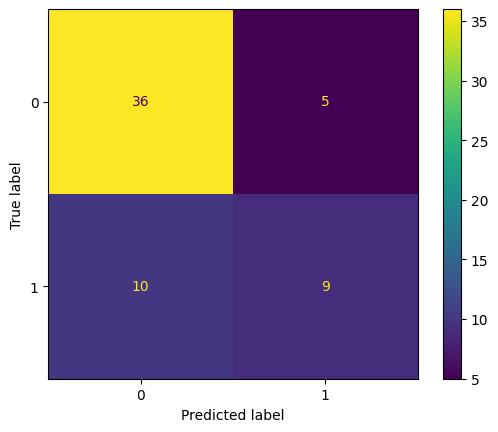

In [54]:
plot_confusion_matrix(xgb_classifier.best_estimator_, X_test, y_test)

In [28]:
xgb_test_pred = np.where(xgb_classifier.predict_proba(X_test)[:,1] > threshold, 1, 0)

xgb_score = random_forest_classifier.score(X_test, y_test)
xgb_precision = precision_score(y_test, xgb_test_pred)
xgb_recall = recall_score(y_test, xgb_test_pred)
xgb_f1_score = f1_score(y_test, xgb_test_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_test_pred)

print('Score = {:.5f}'.format(xgb_score))
print('Precision = {:.5f}'.format(xgb_precision))
print('Recall = {:.5f}'.format(xgb_recall))
print('F1 score = {:.5f}'.format(xgb_f1_score))
print('AUC = {:.5f}'.format(xgb_roc_auc))

Score = 0.81667
Precision = 0.61538
Recall = 0.42105
F1 score = 0.50000
AUC = 0.64955


# CatBoost

In [29]:
cat_boost_grid = [{
    'n_estimators':   np.arange(start = 100, stop = 500, step = 100, dtype=int),
    'max_depth':      np.arange(start = 3, stop = 5, step = 1, dtype=int),
    'learning_rate':  np.arange(start = 0.1, stop = 0.3, step = 0.1)
}]

cat_boost_classifier = GridSearchCV(estimator=CatBoostClassifier(random_state=43), param_grid=cat_boost_grid, cv=3, verbose=3)
cat_boost_classifier.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
0:	learn: 0.6628991	total: 139ms	remaining: 13.8s
1:	learn: 0.6457738	total: 139ms	remaining: 6.83s
2:	learn: 0.6313175	total: 140ms	remaining: 4.52s
3:	learn: 0.6186101	total: 140ms	remaining: 3.36s
4:	learn: 0.6066595	total: 140ms	remaining: 2.67s
5:	learn: 0.5962915	total: 141ms	remaining: 2.21s
6:	learn: 0.5811631	total: 141ms	remaining: 1.88s
7:	learn: 0.5726167	total: 142ms	remaining: 1.63s
8:	learn: 0.5652811	total: 142ms	remaining: 1.43s
9:	learn: 0.5536970	total: 142ms	remaining: 1.28s
10:	learn: 0.5501949	total: 143ms	remaining: 1.15s
11:	learn: 0.5430877	total: 143ms	remaining: 1.05s
12:	learn: 0.5360176	total: 143ms	remaining: 959ms
13:	learn: 0.5285499	total: 144ms	remaining: 882ms
14:	learn: 0.5223507	total: 144ms	remaining: 816ms
15:	learn: 0.5187989	total: 144ms	remaining: 758ms
16:	learn: 0.5138606	total: 145ms	remaining: 706ms
17:	learn: 0.5104663	total: 145ms	remaining: 661ms
18:	learn: 0.5048348	total: 145

54:	learn: 0.2994462	total: 51.7ms	remaining: 136ms
55:	learn: 0.2964941	total: 52.7ms	remaining: 136ms
56:	learn: 0.2943048	total: 53.5ms	remaining: 134ms
57:	learn: 0.2926198	total: 54.4ms	remaining: 133ms
58:	learn: 0.2901756	total: 55.2ms	remaining: 132ms
59:	learn: 0.2886826	total: 56ms	remaining: 131ms
60:	learn: 0.2836451	total: 56.8ms	remaining: 129ms
61:	learn: 0.2813074	total: 57.6ms	remaining: 128ms
62:	learn: 0.2795343	total: 58.4ms	remaining: 127ms
63:	learn: 0.2780256	total: 59.2ms	remaining: 126ms
64:	learn: 0.2760232	total: 60ms	remaining: 125ms
65:	learn: 0.2731136	total: 60.8ms	remaining: 124ms
66:	learn: 0.2717363	total: 61.6ms	remaining: 122ms
67:	learn: 0.2688144	total: 62.5ms	remaining: 121ms
68:	learn: 0.2658617	total: 63.4ms	remaining: 120ms
69:	learn: 0.2617912	total: 64.2ms	remaining: 119ms
70:	learn: 0.2603748	total: 65.1ms	remaining: 118ms
71:	learn: 0.2590972	total: 66.1ms	remaining: 117ms
72:	learn: 0.2564213	total: 66.9ms	remaining: 116ms
73:	learn: 0.253

50:	learn: 0.3275788	total: 44ms	remaining: 128ms
51:	learn: 0.3256032	total: 45.3ms	remaining: 129ms
52:	learn: 0.3236013	total: 46.4ms	remaining: 129ms
53:	learn: 0.3200240	total: 47.5ms	remaining: 129ms
54:	learn: 0.3187059	total: 48.6ms	remaining: 128ms
55:	learn: 0.3152074	total: 49.7ms	remaining: 128ms
56:	learn: 0.3119620	total: 50.7ms	remaining: 127ms
57:	learn: 0.3083026	total: 51.7ms	remaining: 126ms
58:	learn: 0.3033447	total: 52.9ms	remaining: 126ms
59:	learn: 0.3000042	total: 54ms	remaining: 126ms
60:	learn: 0.2953173	total: 54.9ms	remaining: 125ms
61:	learn: 0.2918226	total: 55.8ms	remaining: 124ms
62:	learn: 0.2908787	total: 56.7ms	remaining: 123ms
63:	learn: 0.2873346	total: 57.7ms	remaining: 123ms
64:	learn: 0.2844376	total: 58.5ms	remaining: 122ms
65:	learn: 0.2832091	total: 59.6ms	remaining: 121ms
66:	learn: 0.2821914	total: 60.5ms	remaining: 120ms
67:	learn: 0.2782257	total: 61.5ms	remaining: 119ms
68:	learn: 0.2741876	total: 62.5ms	remaining: 119ms
69:	learn: 0.269

12:	learn: 0.4114033	total: 13.4ms	remaining: 193ms
13:	learn: 0.4030184	total: 14.5ms	remaining: 193ms
14:	learn: 0.3917090	total: 15.7ms	remaining: 193ms
15:	learn: 0.3847005	total: 16.9ms	remaining: 194ms
16:	learn: 0.3807821	total: 17.9ms	remaining: 193ms
17:	learn: 0.3758348	total: 18.9ms	remaining: 191ms
18:	learn: 0.3716873	total: 20.1ms	remaining: 191ms
19:	learn: 0.3682893	total: 21.1ms	remaining: 190ms
20:	learn: 0.3615257	total: 22.3ms	remaining: 191ms
21:	learn: 0.3585349	total: 23.5ms	remaining: 190ms
22:	learn: 0.3529591	total: 24.6ms	remaining: 190ms
23:	learn: 0.3465828	total: 25.8ms	remaining: 189ms
24:	learn: 0.3432143	total: 26.9ms	remaining: 188ms
25:	learn: 0.3400725	total: 27.8ms	remaining: 186ms
26:	learn: 0.3374620	total: 28.9ms	remaining: 185ms
27:	learn: 0.3345456	total: 29.9ms	remaining: 184ms
28:	learn: 0.3290539	total: 31ms	remaining: 183ms
29:	learn: 0.3222544	total: 32.2ms	remaining: 182ms
30:	learn: 0.3191905	total: 33.3ms	remaining: 181ms
31:	learn: 0.3

[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.658 total time=   0.1s
0:	learn: 0.6446102	total: 902us	remaining: 270ms
1:	learn: 0.6176745	total: 1.7ms	remaining: 254ms
2:	learn: 0.6015153	total: 2.48ms	remaining: 246ms
3:	learn: 0.5703030	total: 3.45ms	remaining: 255ms
4:	learn: 0.5495135	total: 4.39ms	remaining: 259ms
5:	learn: 0.5350315	total: 5.25ms	remaining: 257ms
6:	learn: 0.5265237	total: 6.1ms	remaining: 255ms
7:	learn: 0.5098970	total: 6.99ms	remaining: 255ms
8:	learn: 0.4952894	total: 7.96ms	remaining: 258ms
9:	learn: 0.4870499	total: 9.11ms	remaining: 264ms
10:	learn: 0.4811420	total: 10.3ms	remaining: 271ms
11:	learn: 0.4675683	total: 11.4ms	remaining: 273ms
12:	learn: 0.4587449	total: 12.2ms	remaining: 269ms
13:	learn: 0.4502380	total: 13ms	remaining: 266ms
14:	learn: 0.4434048	total: 13.9ms	remaining: 263ms
15:	learn: 0.4370780	total: 14.7ms	remaining: 261ms
16:	learn: 0.4323569	total: 15.5ms	remaining: 259ms
17:	learn: 0.4293543	total: 16.4ms	r

182:	learn: 0.0979647	total: 167ms	remaining: 107ms
183:	learn: 0.0969980	total: 168ms	remaining: 106ms
184:	learn: 0.0968404	total: 169ms	remaining: 105ms
185:	learn: 0.0965372	total: 170ms	remaining: 104ms
186:	learn: 0.0951944	total: 171ms	remaining: 103ms
187:	learn: 0.0949708	total: 172ms	remaining: 103ms
188:	learn: 0.0942187	total: 173ms	remaining: 102ms
189:	learn: 0.0937953	total: 174ms	remaining: 101ms
190:	learn: 0.0935298	total: 174ms	remaining: 99.6ms
191:	learn: 0.0933121	total: 175ms	remaining: 98.6ms
192:	learn: 0.0929950	total: 176ms	remaining: 97.6ms
193:	learn: 0.0926187	total: 177ms	remaining: 96.6ms
194:	learn: 0.0923446	total: 178ms	remaining: 95.7ms
195:	learn: 0.0921000	total: 178ms	remaining: 94.7ms
196:	learn: 0.0917790	total: 179ms	remaining: 93.7ms
197:	learn: 0.0908942	total: 180ms	remaining: 92.8ms
198:	learn: 0.0906822	total: 181ms	remaining: 91.8ms
199:	learn: 0.0904824	total: 182ms	remaining: 90.9ms
200:	learn: 0.0896187	total: 183ms	remaining: 89.9ms
2

62:	learn: 0.2908787	total: 59.5ms	remaining: 224ms
63:	learn: 0.2873346	total: 60.6ms	remaining: 223ms
64:	learn: 0.2844376	total: 61.9ms	remaining: 224ms
65:	learn: 0.2832091	total: 62.9ms	remaining: 223ms
66:	learn: 0.2821914	total: 63.8ms	remaining: 222ms
67:	learn: 0.2782257	total: 64.9ms	remaining: 221ms
68:	learn: 0.2741876	total: 65.8ms	remaining: 220ms
69:	learn: 0.2694025	total: 66.7ms	remaining: 219ms
70:	learn: 0.2657237	total: 67.6ms	remaining: 218ms
71:	learn: 0.2638188	total: 68.5ms	remaining: 217ms
72:	learn: 0.2631282	total: 69.4ms	remaining: 216ms
73:	learn: 0.2624508	total: 70.3ms	remaining: 215ms
74:	learn: 0.2579275	total: 71.1ms	remaining: 213ms
75:	learn: 0.2569673	total: 72ms	remaining: 212ms
76:	learn: 0.2560180	total: 72.9ms	remaining: 211ms
77:	learn: 0.2531581	total: 73.8ms	remaining: 210ms
78:	learn: 0.2497572	total: 74.8ms	remaining: 209ms
79:	learn: 0.2493316	total: 75.8ms	remaining: 208ms
80:	learn: 0.2455654	total: 76.7ms	remaining: 207ms
81:	learn: 0.2

255:	learn: 0.0652398	total: 242ms	remaining: 41.5ms
256:	learn: 0.0649167	total: 243ms	remaining: 40.6ms
257:	learn: 0.0646896	total: 244ms	remaining: 39.6ms
258:	learn: 0.0644097	total: 244ms	remaining: 38.7ms
259:	learn: 0.0641955	total: 245ms	remaining: 37.8ms
260:	learn: 0.0639354	total: 246ms	remaining: 36.8ms
261:	learn: 0.0637451	total: 247ms	remaining: 35.9ms
262:	learn: 0.0636402	total: 248ms	remaining: 34.9ms
263:	learn: 0.0633089	total: 249ms	remaining: 34ms
264:	learn: 0.0629073	total: 250ms	remaining: 33ms
265:	learn: 0.0628100	total: 251ms	remaining: 32.1ms
266:	learn: 0.0627841	total: 252ms	remaining: 31.2ms
267:	learn: 0.0626912	total: 253ms	remaining: 30.2ms
268:	learn: 0.0626256	total: 254ms	remaining: 29.3ms
269:	learn: 0.0623592	total: 256ms	remaining: 28.4ms
270:	learn: 0.0621198	total: 257ms	remaining: 27.5ms
271:	learn: 0.0620361	total: 258ms	remaining: 26.6ms
272:	learn: 0.0618412	total: 259ms	remaining: 25.6ms
273:	learn: 0.0616884	total: 260ms	remaining: 24.7

116:	learn: 0.1386246	total: 116ms	remaining: 182ms
117:	learn: 0.1367699	total: 117ms	remaining: 181ms
118:	learn: 0.1361749	total: 118ms	remaining: 180ms
119:	learn: 0.1351148	total: 119ms	remaining: 179ms
120:	learn: 0.1331931	total: 120ms	remaining: 178ms
121:	learn: 0.1316949	total: 121ms	remaining: 177ms
122:	learn: 0.1295515	total: 122ms	remaining: 176ms
123:	learn: 0.1277972	total: 123ms	remaining: 175ms
124:	learn: 0.1266212	total: 124ms	remaining: 174ms
125:	learn: 0.1254467	total: 125ms	remaining: 173ms
126:	learn: 0.1242028	total: 126ms	remaining: 172ms
127:	learn: 0.1232171	total: 127ms	remaining: 170ms
128:	learn: 0.1228467	total: 128ms	remaining: 169ms
129:	learn: 0.1214479	total: 129ms	remaining: 168ms
130:	learn: 0.1205732	total: 130ms	remaining: 167ms
131:	learn: 0.1192010	total: 131ms	remaining: 166ms
132:	learn: 0.1186738	total: 131ms	remaining: 165ms
133:	learn: 0.1175764	total: 133ms	remaining: 164ms
134:	learn: 0.1158924	total: 134ms	remaining: 163ms
135:	learn: 

0:	learn: 0.6446102	total: 1.01ms	remaining: 405ms
1:	learn: 0.6176745	total: 1.9ms	remaining: 378ms
2:	learn: 0.6015153	total: 2.67ms	remaining: 354ms
3:	learn: 0.5703030	total: 3.54ms	remaining: 351ms
4:	learn: 0.5495135	total: 4.48ms	remaining: 354ms
5:	learn: 0.5350315	total: 5.3ms	remaining: 348ms
6:	learn: 0.5265237	total: 6.17ms	remaining: 346ms
7:	learn: 0.5098970	total: 7.15ms	remaining: 350ms
8:	learn: 0.4952894	total: 8.06ms	remaining: 350ms
9:	learn: 0.4870499	total: 9.08ms	remaining: 354ms
10:	learn: 0.4811420	total: 10.2ms	remaining: 359ms
11:	learn: 0.4675683	total: 11.1ms	remaining: 358ms
12:	learn: 0.4587449	total: 11.9ms	remaining: 355ms
13:	learn: 0.4502380	total: 12.8ms	remaining: 352ms
14:	learn: 0.4434048	total: 13.6ms	remaining: 349ms
15:	learn: 0.4370780	total: 14.4ms	remaining: 346ms
16:	learn: 0.4323569	total: 15.2ms	remaining: 343ms
17:	learn: 0.4293543	total: 16.1ms	remaining: 343ms
18:	learn: 0.4259671	total: 17.1ms	remaining: 342ms
19:	learn: 0.4226685	tot

221:	learn: 0.0767457	total: 193ms	remaining: 155ms
222:	learn: 0.0761427	total: 195ms	remaining: 155ms
223:	learn: 0.0752268	total: 196ms	remaining: 154ms
224:	learn: 0.0748849	total: 197ms	remaining: 153ms
225:	learn: 0.0742500	total: 198ms	remaining: 152ms
226:	learn: 0.0735363	total: 199ms	remaining: 152ms
227:	learn: 0.0733037	total: 200ms	remaining: 151ms
228:	learn: 0.0730415	total: 201ms	remaining: 150ms
229:	learn: 0.0726887	total: 202ms	remaining: 149ms
230:	learn: 0.0725036	total: 203ms	remaining: 148ms
231:	learn: 0.0722802	total: 203ms	remaining: 147ms
232:	learn: 0.0721439	total: 205ms	remaining: 147ms
233:	learn: 0.0717534	total: 206ms	remaining: 146ms
234:	learn: 0.0717002	total: 207ms	remaining: 145ms
235:	learn: 0.0715892	total: 208ms	remaining: 144ms
236:	learn: 0.0712313	total: 209ms	remaining: 144ms
237:	learn: 0.0705728	total: 210ms	remaining: 143ms
238:	learn: 0.0685122	total: 211ms	remaining: 142ms
239:	learn: 0.0683875	total: 212ms	remaining: 141ms
240:	learn: 

0:	learn: 0.6510945	total: 1.2ms	remaining: 479ms
1:	learn: 0.6302349	total: 2.96ms	remaining: 589ms
2:	learn: 0.6149852	total: 4.11ms	remaining: 545ms
3:	learn: 0.5926056	total: 5.41ms	remaining: 535ms
4:	learn: 0.5751129	total: 6.62ms	remaining: 523ms
5:	learn: 0.5663326	total: 7.62ms	remaining: 501ms
6:	learn: 0.5556722	total: 8.52ms	remaining: 478ms
7:	learn: 0.5468323	total: 9.56ms	remaining: 469ms
8:	learn: 0.5385169	total: 10.5ms	remaining: 454ms
9:	learn: 0.5253115	total: 11.4ms	remaining: 446ms
10:	learn: 0.5147400	total: 12.3ms	remaining: 435ms
11:	learn: 0.5074041	total: 13.5ms	remaining: 436ms
12:	learn: 0.4934417	total: 14.6ms	remaining: 436ms
13:	learn: 0.4865163	total: 15.7ms	remaining: 433ms
14:	learn: 0.4787801	total: 17ms	remaining: 435ms
15:	learn: 0.4744975	total: 18.1ms	remaining: 433ms
16:	learn: 0.4685952	total: 19.2ms	remaining: 434ms
17:	learn: 0.4608028	total: 20.3ms	remaining: 430ms
18:	learn: 0.4569430	total: 21.3ms	remaining: 427ms
19:	learn: 0.4516900	tota

191:	learn: 0.0976547	total: 188ms	remaining: 204ms
192:	learn: 0.0975946	total: 189ms	remaining: 203ms
193:	learn: 0.0962204	total: 190ms	remaining: 202ms
194:	learn: 0.0950611	total: 191ms	remaining: 201ms
195:	learn: 0.0939481	total: 192ms	remaining: 200ms
196:	learn: 0.0935658	total: 193ms	remaining: 199ms
197:	learn: 0.0926213	total: 194ms	remaining: 198ms
198:	learn: 0.0925276	total: 195ms	remaining: 196ms
199:	learn: 0.0918296	total: 195ms	remaining: 195ms
200:	learn: 0.0913284	total: 196ms	remaining: 194ms
201:	learn: 0.0912679	total: 197ms	remaining: 193ms
202:	learn: 0.0909262	total: 198ms	remaining: 192ms
203:	learn: 0.0908756	total: 199ms	remaining: 191ms
204:	learn: 0.0900984	total: 200ms	remaining: 190ms
205:	learn: 0.0900380	total: 200ms	remaining: 189ms
206:	learn: 0.0894221	total: 201ms	remaining: 188ms
207:	learn: 0.0891640	total: 202ms	remaining: 186ms
208:	learn: 0.0884512	total: 203ms	remaining: 185ms
209:	learn: 0.0876077	total: 204ms	remaining: 184ms
210:	learn: 

383:	learn: 0.0339742	total: 371ms	remaining: 15.5ms
384:	learn: 0.0339639	total: 372ms	remaining: 14.5ms
385:	learn: 0.0339279	total: 374ms	remaining: 13.6ms
386:	learn: 0.0338279	total: 375ms	remaining: 12.6ms
387:	learn: 0.0336996	total: 376ms	remaining: 11.6ms
388:	learn: 0.0333871	total: 377ms	remaining: 10.6ms
389:	learn: 0.0329127	total: 377ms	remaining: 9.68ms
390:	learn: 0.0327949	total: 378ms	remaining: 8.71ms
391:	learn: 0.0326143	total: 379ms	remaining: 7.74ms
392:	learn: 0.0324646	total: 380ms	remaining: 6.77ms
393:	learn: 0.0322994	total: 381ms	remaining: 5.8ms
394:	learn: 0.0322056	total: 382ms	remaining: 4.84ms
395:	learn: 0.0321896	total: 383ms	remaining: 3.87ms
396:	learn: 0.0319970	total: 384ms	remaining: 2.9ms
397:	learn: 0.0319117	total: 385ms	remaining: 1.93ms
398:	learn: 0.0319024	total: 386ms	remaining: 966us
399:	learn: 0.0318233	total: 386ms	remaining: 0us
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=400;, score=0.688 total time=   0.4s
0:	learn: 

158:	learn: 0.0984037	total: 148ms	remaining: 225ms
159:	learn: 0.0983175	total: 149ms	remaining: 224ms
160:	learn: 0.0980694	total: 151ms	remaining: 223ms
161:	learn: 0.0966080	total: 152ms	remaining: 223ms
162:	learn: 0.0960018	total: 153ms	remaining: 222ms
163:	learn: 0.0941891	total: 153ms	remaining: 221ms
164:	learn: 0.0930811	total: 155ms	remaining: 220ms
165:	learn: 0.0925613	total: 156ms	remaining: 220ms
166:	learn: 0.0913170	total: 157ms	remaining: 219ms
167:	learn: 0.0901293	total: 158ms	remaining: 218ms
168:	learn: 0.0891708	total: 159ms	remaining: 217ms
169:	learn: 0.0890272	total: 160ms	remaining: 217ms
170:	learn: 0.0888809	total: 161ms	remaining: 216ms
171:	learn: 0.0888067	total: 162ms	remaining: 215ms
172:	learn: 0.0884086	total: 163ms	remaining: 214ms
173:	learn: 0.0878445	total: 164ms	remaining: 213ms
174:	learn: 0.0874885	total: 165ms	remaining: 212ms
175:	learn: 0.0868639	total: 166ms	remaining: 211ms
176:	learn: 0.0861665	total: 167ms	remaining: 210ms
177:	learn: 

357:	learn: 0.0373449	total: 334ms	remaining: 39.2ms
358:	learn: 0.0372770	total: 335ms	remaining: 38.2ms
359:	learn: 0.0372608	total: 336ms	remaining: 37.4ms
360:	learn: 0.0372382	total: 337ms	remaining: 36.4ms
361:	learn: 0.0371001	total: 338ms	remaining: 35.5ms
362:	learn: 0.0370299	total: 339ms	remaining: 34.6ms
363:	learn: 0.0370087	total: 340ms	remaining: 33.7ms
364:	learn: 0.0366494	total: 341ms	remaining: 32.7ms
365:	learn: 0.0364505	total: 342ms	remaining: 31.8ms
366:	learn: 0.0363789	total: 343ms	remaining: 30.8ms
367:	learn: 0.0363673	total: 344ms	remaining: 29.9ms
368:	learn: 0.0363031	total: 345ms	remaining: 29ms
369:	learn: 0.0362531	total: 345ms	remaining: 28ms
370:	learn: 0.0360182	total: 346ms	remaining: 27.1ms
371:	learn: 0.0359662	total: 347ms	remaining: 26.1ms
372:	learn: 0.0359528	total: 348ms	remaining: 25.2ms
373:	learn: 0.0357290	total: 349ms	remaining: 24.3ms
374:	learn: 0.0353094	total: 350ms	remaining: 23.3ms
375:	learn: 0.0349913	total: 351ms	remaining: 22.4

99:	learn: 0.3043476	total: 43.3ms	remaining: 0us
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=100;, score=0.762 total time=   0.0s
0:	learn: 0.6579719	total: 587us	remaining: 58.2ms
1:	learn: 0.6329065	total: 1.15ms	remaining: 56.3ms
2:	learn: 0.6107084	total: 1.59ms	remaining: 51.4ms
3:	learn: 0.5903748	total: 2.02ms	remaining: 48.5ms
4:	learn: 0.5764207	total: 2.44ms	remaining: 46.3ms
5:	learn: 0.5595672	total: 2.84ms	remaining: 44.5ms
6:	learn: 0.5469300	total: 3.23ms	remaining: 43ms
7:	learn: 0.5337356	total: 3.58ms	remaining: 41.2ms
8:	learn: 0.5229427	total: 4.05ms	remaining: 41ms
9:	learn: 0.5149752	total: 4.45ms	remaining: 40ms
10:	learn: 0.5073641	total: 4.9ms	remaining: 39.6ms
11:	learn: 0.4984359	total: 5.31ms	remaining: 39ms
12:	learn: 0.4923820	total: 5.74ms	remaining: 38.4ms
13:	learn: 0.4840348	total: 6.15ms	remaining: 37.8ms
14:	learn: 0.4784288	total: 6.55ms	remaining: 37.1ms
15:	learn: 0.4691868	total: 7ms	remaining: 36.8ms
16:	learn: 0.4629891	total: 7.

101:	learn: 0.1282752	total: 99.2ms	remaining: 95.3ms
102:	learn: 0.1262881	total: 100ms	remaining: 94.5ms
103:	learn: 0.1254054	total: 102ms	remaining: 93.9ms
104:	learn: 0.1248131	total: 103ms	remaining: 93.2ms
105:	learn: 0.1239487	total: 104ms	remaining: 92.3ms
106:	learn: 0.1219976	total: 105ms	remaining: 91.5ms
107:	learn: 0.1213638	total: 107ms	remaining: 90.9ms
108:	learn: 0.1197070	total: 108ms	remaining: 90.1ms
109:	learn: 0.1163294	total: 109ms	remaining: 89.3ms
110:	learn: 0.1136812	total: 110ms	remaining: 88.6ms
111:	learn: 0.1115794	total: 112ms	remaining: 87.7ms
112:	learn: 0.1110058	total: 113ms	remaining: 86.7ms
113:	learn: 0.1092989	total: 114ms	remaining: 85.8ms
114:	learn: 0.1086336	total: 115ms	remaining: 84.8ms
115:	learn: 0.1076190	total: 116ms	remaining: 83.8ms
116:	learn: 0.1051864	total: 117ms	remaining: 82.9ms
117:	learn: 0.1037728	total: 118ms	remaining: 82ms
118:	learn: 0.1026746	total: 119ms	remaining: 81ms
119:	learn: 0.1022437	total: 120ms	remaining: 80.

196:	learn: 0.0434618	total: 236ms	remaining: 3.6ms
197:	learn: 0.0433950	total: 237ms	remaining: 2.4ms
198:	learn: 0.0432527	total: 238ms	remaining: 1.2ms
199:	learn: 0.0429630	total: 239ms	remaining: 0us
[CV 2/3] END learning_rate=0.1, max_depth=4, n_estimators=200;, score=0.725 total time=   0.2s
0:	learn: 0.6282819	total: 1.07ms	remaining: 214ms
1:	learn: 0.5878470	total: 2.19ms	remaining: 217ms
2:	learn: 0.5625375	total: 3.17ms	remaining: 208ms
3:	learn: 0.5342497	total: 4.27ms	remaining: 209ms
4:	learn: 0.5125044	total: 5.41ms	remaining: 211ms
5:	learn: 0.4977007	total: 6.39ms	remaining: 207ms
6:	learn: 0.4771550	total: 7.33ms	remaining: 202ms
7:	learn: 0.4538420	total: 8.25ms	remaining: 198ms
8:	learn: 0.4425332	total: 9.25ms	remaining: 196ms
9:	learn: 0.4304568	total: 10.2ms	remaining: 194ms
10:	learn: 0.4189307	total: 11.1ms	remaining: 191ms
11:	learn: 0.4062613	total: 12.1ms	remaining: 189ms
12:	learn: 0.3978410	total: 13.1ms	remaining: 188ms
13:	learn: 0.3913477	total: 14.1m

163:	learn: 0.0495633	total: 162ms	remaining: 35.5ms
164:	learn: 0.0485209	total: 163ms	remaining: 34.6ms
165:	learn: 0.0480791	total: 164ms	remaining: 33.7ms
166:	learn: 0.0477880	total: 165ms	remaining: 32.7ms
167:	learn: 0.0477506	total: 166ms	remaining: 31.7ms
168:	learn: 0.0477094	total: 167ms	remaining: 30.7ms
169:	learn: 0.0476246	total: 168ms	remaining: 29.7ms
170:	learn: 0.0475302	total: 169ms	remaining: 28.7ms
171:	learn: 0.0474980	total: 170ms	remaining: 27.7ms
172:	learn: 0.0474670	total: 172ms	remaining: 26.8ms
173:	learn: 0.0471523	total: 173ms	remaining: 25.8ms
174:	learn: 0.0470660	total: 174ms	remaining: 24.8ms
175:	learn: 0.0460840	total: 175ms	remaining: 23.9ms
176:	learn: 0.0460545	total: 176ms	remaining: 22.9ms
177:	learn: 0.0459583	total: 177ms	remaining: 21.9ms
178:	learn: 0.0458634	total: 179ms	remaining: 21ms
179:	learn: 0.0447584	total: 180ms	remaining: 20ms
180:	learn: 0.0445833	total: 181ms	remaining: 19ms
181:	learn: 0.0441758	total: 182ms	remaining: 18ms
1

133:	learn: 0.0905558	total: 129ms	remaining: 159ms
134:	learn: 0.0882808	total: 130ms	remaining: 159ms
135:	learn: 0.0864249	total: 131ms	remaining: 158ms
136:	learn: 0.0850944	total: 132ms	remaining: 157ms
137:	learn: 0.0838688	total: 133ms	remaining: 156ms
138:	learn: 0.0827888	total: 134ms	remaining: 155ms
139:	learn: 0.0825043	total: 135ms	remaining: 154ms
140:	learn: 0.0822502	total: 136ms	remaining: 153ms
141:	learn: 0.0815332	total: 137ms	remaining: 152ms
142:	learn: 0.0790673	total: 138ms	remaining: 151ms
143:	learn: 0.0778328	total: 139ms	remaining: 150ms
144:	learn: 0.0776257	total: 140ms	remaining: 149ms
145:	learn: 0.0766065	total: 141ms	remaining: 148ms
146:	learn: 0.0764847	total: 142ms	remaining: 147ms
147:	learn: 0.0757783	total: 143ms	remaining: 146ms
148:	learn: 0.0753377	total: 143ms	remaining: 145ms
149:	learn: 0.0744045	total: 144ms	remaining: 144ms
150:	learn: 0.0734761	total: 145ms	remaining: 143ms
151:	learn: 0.0727278	total: 146ms	remaining: 142ms
152:	learn: 

0:	learn: 0.6466227	total: 1.34ms	remaining: 400ms
1:	learn: 0.6151971	total: 2.57ms	remaining: 382ms
2:	learn: 0.5869080	total: 3.8ms	remaining: 376ms
3:	learn: 0.5680381	total: 4.97ms	remaining: 368ms
4:	learn: 0.5401853	total: 5.94ms	remaining: 350ms
5:	learn: 0.5189374	total: 6.99ms	remaining: 342ms
6:	learn: 0.5056893	total: 7.95ms	remaining: 333ms
7:	learn: 0.4886983	total: 8.97ms	remaining: 327ms
8:	learn: 0.4809138	total: 9.98ms	remaining: 323ms
9:	learn: 0.4716844	total: 11ms	remaining: 318ms
10:	learn: 0.4640315	total: 12.1ms	remaining: 318ms
11:	learn: 0.4562427	total: 13.4ms	remaining: 322ms
12:	learn: 0.4493086	total: 14.6ms	remaining: 323ms
13:	learn: 0.4411152	total: 15.9ms	remaining: 325ms
14:	learn: 0.4312416	total: 17.1ms	remaining: 324ms
15:	learn: 0.4248830	total: 18.2ms	remaining: 323ms
16:	learn: 0.4174622	total: 19.5ms	remaining: 325ms
17:	learn: 0.4088827	total: 20.9ms	remaining: 328ms
18:	learn: 0.4062754	total: 22.2ms	remaining: 329ms
19:	learn: 0.4008442	tota

5:	learn: 0.4977007	total: 6.65ms	remaining: 326ms
6:	learn: 0.4771550	total: 7.77ms	remaining: 325ms
7:	learn: 0.4538420	total: 9.04ms	remaining: 330ms
8:	learn: 0.4425332	total: 10ms	remaining: 325ms
9:	learn: 0.4304568	total: 11.1ms	remaining: 321ms
10:	learn: 0.4189307	total: 12.1ms	remaining: 319ms
11:	learn: 0.4062613	total: 13.4ms	remaining: 321ms
12:	learn: 0.3978410	total: 14.3ms	remaining: 315ms
13:	learn: 0.3913477	total: 15.2ms	remaining: 311ms
14:	learn: 0.3811383	total: 16.1ms	remaining: 306ms
15:	learn: 0.3716331	total: 17ms	remaining: 302ms
16:	learn: 0.3601869	total: 18ms	remaining: 299ms
17:	learn: 0.3527541	total: 18.8ms	remaining: 295ms
18:	learn: 0.3418880	total: 19.8ms	remaining: 293ms
19:	learn: 0.3390424	total: 20.9ms	remaining: 293ms
20:	learn: 0.3317950	total: 21.9ms	remaining: 291ms
21:	learn: 0.3261280	total: 22.7ms	remaining: 287ms
22:	learn: 0.3218197	total: 23.6ms	remaining: 284ms
23:	learn: 0.3152353	total: 24.8ms	remaining: 285ms
24:	learn: 0.3112227	to

185:	learn: 0.0421077	total: 192ms	remaining: 118ms
186:	learn: 0.0419349	total: 193ms	remaining: 117ms
187:	learn: 0.0414008	total: 194ms	remaining: 116ms
188:	learn: 0.0409216	total: 196ms	remaining: 115ms
189:	learn: 0.0407818	total: 197ms	remaining: 114ms
190:	learn: 0.0401175	total: 198ms	remaining: 113ms
191:	learn: 0.0395720	total: 199ms	remaining: 112ms
192:	learn: 0.0387764	total: 200ms	remaining: 111ms
193:	learn: 0.0381493	total: 201ms	remaining: 110ms
194:	learn: 0.0381227	total: 202ms	remaining: 109ms
195:	learn: 0.0378846	total: 203ms	remaining: 108ms
196:	learn: 0.0377435	total: 204ms	remaining: 106ms
197:	learn: 0.0377191	total: 204ms	remaining: 105ms
198:	learn: 0.0370270	total: 205ms	remaining: 104ms
199:	learn: 0.0365344	total: 206ms	remaining: 103ms
200:	learn: 0.0364578	total: 207ms	remaining: 102ms
201:	learn: 0.0363544	total: 208ms	remaining: 101ms
202:	learn: 0.0363311	total: 209ms	remaining: 100ms
203:	learn: 0.0361413	total: 210ms	remaining: 98.9ms
204:	learn:

46:	learn: 0.2692913	total: 53.4ms	remaining: 401ms
47:	learn: 0.2643513	total: 54.8ms	remaining: 402ms
48:	learn: 0.2588369	total: 55.9ms	remaining: 401ms
49:	learn: 0.2561639	total: 57.1ms	remaining: 399ms
50:	learn: 0.2532084	total: 58.2ms	remaining: 398ms
51:	learn: 0.2506741	total: 59.2ms	remaining: 396ms
52:	learn: 0.2458263	total: 60.4ms	remaining: 395ms
53:	learn: 0.2413808	total: 61.6ms	remaining: 394ms
54:	learn: 0.2366120	total: 62.7ms	remaining: 393ms
55:	learn: 0.2337762	total: 63.7ms	remaining: 391ms
56:	learn: 0.2302791	total: 64.7ms	remaining: 389ms
57:	learn: 0.2270835	total: 65.8ms	remaining: 388ms
58:	learn: 0.2237350	total: 66.9ms	remaining: 387ms
59:	learn: 0.2202442	total: 68ms	remaining: 385ms
60:	learn: 0.2171920	total: 69ms	remaining: 384ms
61:	learn: 0.2151491	total: 70ms	remaining: 382ms
62:	learn: 0.2121205	total: 71.1ms	remaining: 381ms
63:	learn: 0.2090746	total: 72.1ms	remaining: 379ms
64:	learn: 0.2064897	total: 73.2ms	remaining: 377ms
65:	learn: 0.20354

223:	learn: 0.0428404	total: 238ms	remaining: 187ms
224:	learn: 0.0423529	total: 239ms	remaining: 186ms
225:	learn: 0.0420155	total: 240ms	remaining: 185ms
226:	learn: 0.0417056	total: 241ms	remaining: 184ms
227:	learn: 0.0416547	total: 242ms	remaining: 183ms
228:	learn: 0.0415577	total: 243ms	remaining: 182ms
229:	learn: 0.0411687	total: 245ms	remaining: 181ms
230:	learn: 0.0406820	total: 246ms	remaining: 180ms
231:	learn: 0.0406229	total: 247ms	remaining: 179ms
232:	learn: 0.0403099	total: 248ms	remaining: 177ms
233:	learn: 0.0401413	total: 249ms	remaining: 176ms
234:	learn: 0.0400816	total: 250ms	remaining: 175ms
235:	learn: 0.0399669	total: 251ms	remaining: 174ms
236:	learn: 0.0398663	total: 251ms	remaining: 173ms
237:	learn: 0.0397422	total: 253ms	remaining: 172ms
238:	learn: 0.0396122	total: 254ms	remaining: 171ms
239:	learn: 0.0395263	total: 255ms	remaining: 170ms
240:	learn: 0.0394202	total: 256ms	remaining: 169ms
241:	learn: 0.0392976	total: 258ms	remaining: 168ms
242:	learn: 

388:	learn: 0.0190975	total: 422ms	remaining: 11.9ms
389:	learn: 0.0190799	total: 423ms	remaining: 10.9ms
390:	learn: 0.0190035	total: 424ms	remaining: 9.77ms
391:	learn: 0.0189764	total: 425ms	remaining: 8.68ms
392:	learn: 0.0189689	total: 427ms	remaining: 7.6ms
393:	learn: 0.0189384	total: 428ms	remaining: 6.51ms
394:	learn: 0.0189032	total: 429ms	remaining: 5.43ms
395:	learn: 0.0188001	total: 430ms	remaining: 4.34ms
396:	learn: 0.0186986	total: 431ms	remaining: 3.26ms
397:	learn: 0.0184808	total: 432ms	remaining: 2.17ms
398:	learn: 0.0184000	total: 434ms	remaining: 1.09ms
399:	learn: 0.0183799	total: 435ms	remaining: 0us
[CV 1/3] END learning_rate=0.1, max_depth=4, n_estimators=400;, score=0.725 total time=   0.4s
0:	learn: 0.6466227	total: 1.27ms	remaining: 509ms
1:	learn: 0.6151971	total: 2.44ms	remaining: 486ms
2:	learn: 0.5869080	total: 3.52ms	remaining: 466ms
3:	learn: 0.5680381	total: 4.64ms	remaining: 460ms
4:	learn: 0.5401853	total: 5.86ms	remaining: 463ms
5:	learn: 0.518937

322:	learn: 0.0198613	total: 330ms	remaining: 78.6ms
323:	learn: 0.0197864	total: 331ms	remaining: 77.7ms
324:	learn: 0.0197127	total: 332ms	remaining: 76.7ms
325:	learn: 0.0196455	total: 334ms	remaining: 75.7ms
326:	learn: 0.0195865	total: 335ms	remaining: 74.7ms
327:	learn: 0.0195687	total: 336ms	remaining: 73.7ms
328:	learn: 0.0194836	total: 337ms	remaining: 72.6ms
329:	learn: 0.0194318	total: 338ms	remaining: 71.6ms
330:	learn: 0.0193862	total: 339ms	remaining: 70.6ms
331:	learn: 0.0192334	total: 340ms	remaining: 69.5ms
332:	learn: 0.0191155	total: 341ms	remaining: 68.5ms
333:	learn: 0.0191091	total: 341ms	remaining: 67.5ms
334:	learn: 0.0190944	total: 342ms	remaining: 66.4ms
335:	learn: 0.0189862	total: 343ms	remaining: 65.4ms
336:	learn: 0.0187664	total: 344ms	remaining: 64.4ms
337:	learn: 0.0186366	total: 345ms	remaining: 63.3ms
338:	learn: 0.0185621	total: 346ms	remaining: 62.3ms
339:	learn: 0.0184675	total: 347ms	remaining: 61.2ms
340:	learn: 0.0183439	total: 348ms	remaining: 

87:	learn: 0.1392265	total: 86.5ms	remaining: 307ms
88:	learn: 0.1363946	total: 88ms	remaining: 307ms
89:	learn: 0.1344306	total: 89ms	remaining: 307ms
90:	learn: 0.1309622	total: 90ms	remaining: 306ms
91:	learn: 0.1283404	total: 91ms	remaining: 305ms
92:	learn: 0.1272649	total: 91.9ms	remaining: 303ms
93:	learn: 0.1256548	total: 92.9ms	remaining: 302ms
94:	learn: 0.1255581	total: 93.8ms	remaining: 301ms
95:	learn: 0.1231861	total: 94.8ms	remaining: 300ms
96:	learn: 0.1227757	total: 95.8ms	remaining: 299ms
97:	learn: 0.1187869	total: 96.8ms	remaining: 298ms
98:	learn: 0.1153772	total: 97.7ms	remaining: 297ms
99:	learn: 0.1124195	total: 98.6ms	remaining: 296ms
100:	learn: 0.1099279	total: 99.5ms	remaining: 295ms
101:	learn: 0.1085202	total: 100ms	remaining: 293ms
102:	learn: 0.1071795	total: 101ms	remaining: 292ms
103:	learn: 0.1043901	total: 102ms	remaining: 291ms
104:	learn: 0.1017327	total: 103ms	remaining: 291ms
105:	learn: 0.0997668	total: 105ms	remaining: 290ms
106:	learn: 0.09762

268:	learn: 0.0247068	total: 270ms	remaining: 131ms
269:	learn: 0.0242999	total: 271ms	remaining: 130ms
270:	learn: 0.0241292	total: 272ms	remaining: 130ms
271:	learn: 0.0239103	total: 273ms	remaining: 128ms
272:	learn: 0.0238264	total: 274ms	remaining: 127ms
273:	learn: 0.0237137	total: 275ms	remaining: 126ms
274:	learn: 0.0235330	total: 276ms	remaining: 125ms
275:	learn: 0.0234573	total: 277ms	remaining: 124ms
276:	learn: 0.0231268	total: 278ms	remaining: 123ms
277:	learn: 0.0230035	total: 279ms	remaining: 122ms
278:	learn: 0.0228686	total: 280ms	remaining: 121ms
279:	learn: 0.0228358	total: 280ms	remaining: 120ms
280:	learn: 0.0226292	total: 281ms	remaining: 119ms
281:	learn: 0.0224031	total: 282ms	remaining: 118ms
282:	learn: 0.0223255	total: 283ms	remaining: 117ms
283:	learn: 0.0223122	total: 285ms	remaining: 116ms
284:	learn: 0.0222932	total: 286ms	remaining: 116ms
285:	learn: 0.0222212	total: 287ms	remaining: 115ms
286:	learn: 0.0220093	total: 288ms	remaining: 114ms
287:	learn: 

21:	learn: 0.3339845	total: 20ms	remaining: 162ms
22:	learn: 0.3270263	total: 21ms	remaining: 162ms
23:	learn: 0.3220538	total: 21.9ms	remaining: 161ms
24:	learn: 0.3170006	total: 22.7ms	remaining: 159ms
25:	learn: 0.3104683	total: 23.6ms	remaining: 158ms
26:	learn: 0.3033380	total: 24.4ms	remaining: 156ms
27:	learn: 0.2979718	total: 25.2ms	remaining: 155ms
28:	learn: 0.2908621	total: 26ms	remaining: 153ms
29:	learn: 0.2840204	total: 26.8ms	remaining: 152ms
30:	learn: 0.2792957	total: 27.6ms	remaining: 150ms
31:	learn: 0.2748898	total: 28.4ms	remaining: 149ms
32:	learn: 0.2688941	total: 29.1ms	remaining: 147ms
33:	learn: 0.2617698	total: 30ms	remaining: 146ms
34:	learn: 0.2555605	total: 30.8ms	remaining: 145ms
35:	learn: 0.2533188	total: 31.5ms	remaining: 144ms
36:	learn: 0.2517742	total: 32.4ms	remaining: 143ms
37:	learn: 0.2428220	total: 33.3ms	remaining: 142ms
38:	learn: 0.2399971	total: 34.2ms	remaining: 141ms
39:	learn: 0.2370971	total: 35.3ms	remaining: 141ms
40:	learn: 0.2349679

0:	learn: 0.6145752	total: 1.04ms	remaining: 207ms
1:	learn: 0.5832723	total: 2.1ms	remaining: 208ms
2:	learn: 0.5635560	total: 3.12ms	remaining: 205ms
3:	learn: 0.5332219	total: 4.31ms	remaining: 211ms
4:	learn: 0.5146432	total: 5.5ms	remaining: 215ms
5:	learn: 0.5045066	total: 6.68ms	remaining: 216ms
6:	learn: 0.4918888	total: 7.9ms	remaining: 218ms
7:	learn: 0.4822022	total: 9.17ms	remaining: 220ms
8:	learn: 0.4721567	total: 10.4ms	remaining: 222ms
9:	learn: 0.4595042	total: 11.5ms	remaining: 218ms
10:	learn: 0.4462989	total: 12.6ms	remaining: 217ms
11:	learn: 0.4385846	total: 13.6ms	remaining: 213ms
12:	learn: 0.4313223	total: 14.6ms	remaining: 211ms
13:	learn: 0.4192956	total: 15.7ms	remaining: 208ms
14:	learn: 0.4138158	total: 16.6ms	remaining: 205ms
15:	learn: 0.3988048	total: 17.7ms	remaining: 204ms
16:	learn: 0.3929837	total: 18.8ms	remaining: 202ms
17:	learn: 0.3857053	total: 19.9ms	remaining: 201ms
18:	learn: 0.3809549	total: 20.9ms	remaining: 199ms
19:	learn: 0.3749157	tota

0:	learn: 0.5747535	total: 1.07ms	remaining: 213ms
1:	learn: 0.5297570	total: 2.27ms	remaining: 225ms
2:	learn: 0.5033266	total: 3.11ms	remaining: 205ms
3:	learn: 0.4673702	total: 4.06ms	remaining: 199ms
4:	learn: 0.4236894	total: 4.89ms	remaining: 191ms
5:	learn: 0.4098236	total: 5.68ms	remaining: 184ms
6:	learn: 0.3998764	total: 6.55ms	remaining: 181ms
7:	learn: 0.3832171	total: 7.45ms	remaining: 179ms
8:	learn: 0.3748159	total: 8.31ms	remaining: 176ms
9:	learn: 0.3628775	total: 9.11ms	remaining: 173ms
10:	learn: 0.3568969	total: 9.9ms	remaining: 170ms
11:	learn: 0.3500812	total: 10.7ms	remaining: 168ms
12:	learn: 0.3451339	total: 11.6ms	remaining: 167ms
13:	learn: 0.3374029	total: 12.5ms	remaining: 166ms
14:	learn: 0.3347760	total: 13.3ms	remaining: 164ms
15:	learn: 0.3258948	total: 14.1ms	remaining: 162ms
16:	learn: 0.3217824	total: 14.9ms	remaining: 161ms
17:	learn: 0.3129863	total: 15.7ms	remaining: 159ms
18:	learn: 0.3093848	total: 16.5ms	remaining: 157ms
19:	learn: 0.3032523	to

0:	learn: 0.6030672	total: 1.01ms	remaining: 302ms
1:	learn: 0.5645084	total: 2.12ms	remaining: 316ms
2:	learn: 0.5449464	total: 3.17ms	remaining: 314ms
3:	learn: 0.5061715	total: 4.05ms	remaining: 299ms
4:	learn: 0.4831510	total: 4.98ms	remaining: 294ms
5:	learn: 0.4702242	total: 5.93ms	remaining: 291ms
6:	learn: 0.4627289	total: 7.09ms	remaining: 297ms
7:	learn: 0.4512896	total: 8.07ms	remaining: 295ms
8:	learn: 0.4345978	total: 9.06ms	remaining: 293ms
9:	learn: 0.4272199	total: 9.93ms	remaining: 288ms
10:	learn: 0.4224393	total: 10.8ms	remaining: 284ms
11:	learn: 0.4028587	total: 11.7ms	remaining: 281ms
12:	learn: 0.3955048	total: 12.9ms	remaining: 285ms
13:	learn: 0.3868585	total: 14ms	remaining: 285ms
14:	learn: 0.3786578	total: 14.9ms	remaining: 283ms
15:	learn: 0.3714556	total: 15.8ms	remaining: 280ms
16:	learn: 0.3666960	total: 16.9ms	remaining: 282ms
17:	learn: 0.3627839	total: 17.8ms	remaining: 280ms
18:	learn: 0.3552418	total: 18.7ms	remaining: 277ms
19:	learn: 0.3468971	tot

192:	learn: 0.0330985	total: 188ms	remaining: 104ms
193:	learn: 0.0329085	total: 189ms	remaining: 103ms
194:	learn: 0.0327699	total: 190ms	remaining: 102ms
195:	learn: 0.0325538	total: 191ms	remaining: 102ms
196:	learn: 0.0324566	total: 192ms	remaining: 101ms
197:	learn: 0.0323771	total: 193ms	remaining: 99.5ms
198:	learn: 0.0323203	total: 194ms	remaining: 98.6ms
199:	learn: 0.0322071	total: 195ms	remaining: 97.7ms
200:	learn: 0.0320643	total: 197ms	remaining: 96.9ms
201:	learn: 0.0315296	total: 198ms	remaining: 95.9ms
202:	learn: 0.0313745	total: 199ms	remaining: 95ms
203:	learn: 0.0312112	total: 200ms	remaining: 94.1ms
204:	learn: 0.0310971	total: 201ms	remaining: 93.2ms
205:	learn: 0.0310158	total: 202ms	remaining: 92.3ms
206:	learn: 0.0309325	total: 203ms	remaining: 91.4ms
207:	learn: 0.0307749	total: 204ms	remaining: 90.4ms
208:	learn: 0.0307093	total: 205ms	remaining: 89.4ms
209:	learn: 0.0306106	total: 206ms	remaining: 88.4ms
210:	learn: 0.0305425	total: 207ms	remaining: 87.4ms


55:	learn: 0.1784725	total: 55.4ms	remaining: 242ms
56:	learn: 0.1776945	total: 56.9ms	remaining: 243ms
57:	learn: 0.1716310	total: 58.2ms	remaining: 243ms
58:	learn: 0.1695195	total: 59.3ms	remaining: 242ms
59:	learn: 0.1668914	total: 60.2ms	remaining: 241ms
60:	learn: 0.1640067	total: 61.1ms	remaining: 239ms
61:	learn: 0.1618936	total: 61.9ms	remaining: 238ms
62:	learn: 0.1615273	total: 63ms	remaining: 237ms
63:	learn: 0.1598813	total: 64ms	remaining: 236ms
64:	learn: 0.1556753	total: 64.9ms	remaining: 235ms
65:	learn: 0.1542200	total: 65.7ms	remaining: 233ms
66:	learn: 0.1516861	total: 66.7ms	remaining: 232ms
67:	learn: 0.1511335	total: 67.6ms	remaining: 231ms
68:	learn: 0.1488273	total: 68.5ms	remaining: 229ms
69:	learn: 0.1461503	total: 69.4ms	remaining: 228ms
70:	learn: 0.1433235	total: 70.6ms	remaining: 228ms
71:	learn: 0.1381661	total: 71.6ms	remaining: 227ms
72:	learn: 0.1329158	total: 72.7ms	remaining: 226ms
73:	learn: 0.1295596	total: 73.7ms	remaining: 225ms
74:	learn: 0.127

248:	learn: 0.0200059	total: 237ms	remaining: 48.4ms
249:	learn: 0.0197716	total: 238ms	remaining: 47.6ms
250:	learn: 0.0196369	total: 239ms	remaining: 46.6ms
251:	learn: 0.0195736	total: 240ms	remaining: 45.7ms
252:	learn: 0.0194696	total: 241ms	remaining: 44.7ms
253:	learn: 0.0193343	total: 242ms	remaining: 43.8ms
254:	learn: 0.0188844	total: 243ms	remaining: 42.8ms
255:	learn: 0.0187807	total: 244ms	remaining: 41.9ms
256:	learn: 0.0185730	total: 245ms	remaining: 40.9ms
257:	learn: 0.0183970	total: 245ms	remaining: 40ms
258:	learn: 0.0182466	total: 246ms	remaining: 39ms
259:	learn: 0.0180841	total: 247ms	remaining: 38ms
260:	learn: 0.0179338	total: 248ms	remaining: 37.1ms
261:	learn: 0.0177981	total: 249ms	remaining: 36.2ms
262:	learn: 0.0175929	total: 251ms	remaining: 35.2ms
263:	learn: 0.0174593	total: 252ms	remaining: 34.3ms
264:	learn: 0.0174030	total: 253ms	remaining: 33.4ms
265:	learn: 0.0173776	total: 254ms	remaining: 32.5ms
266:	learn: 0.0172491	total: 255ms	remaining: 31.5ms

122:	learn: 0.0559986	total: 116ms	remaining: 166ms
123:	learn: 0.0558876	total: 117ms	remaining: 166ms
124:	learn: 0.0557248	total: 118ms	remaining: 165ms
125:	learn: 0.0542359	total: 119ms	remaining: 164ms
126:	learn: 0.0531988	total: 120ms	remaining: 164ms
127:	learn: 0.0523137	total: 121ms	remaining: 163ms
128:	learn: 0.0515419	total: 122ms	remaining: 162ms
129:	learn: 0.0510807	total: 123ms	remaining: 161ms
130:	learn: 0.0503674	total: 124ms	remaining: 160ms
131:	learn: 0.0501195	total: 125ms	remaining: 159ms
132:	learn: 0.0494405	total: 126ms	remaining: 158ms
133:	learn: 0.0490400	total: 127ms	remaining: 157ms
134:	learn: 0.0479429	total: 128ms	remaining: 156ms
135:	learn: 0.0478534	total: 129ms	remaining: 155ms
136:	learn: 0.0477977	total: 129ms	remaining: 154ms
137:	learn: 0.0474267	total: 130ms	remaining: 153ms
138:	learn: 0.0465899	total: 131ms	remaining: 152ms
139:	learn: 0.0463555	total: 132ms	remaining: 151ms
140:	learn: 0.0462978	total: 133ms	remaining: 150ms
141:	learn: 

7:	learn: 0.4512896	total: 8.13ms	remaining: 399ms
8:	learn: 0.4345978	total: 9.28ms	remaining: 403ms
9:	learn: 0.4272199	total: 10.5ms	remaining: 410ms
10:	learn: 0.4224393	total: 11.7ms	remaining: 415ms
11:	learn: 0.4028587	total: 12.8ms	remaining: 414ms
12:	learn: 0.3955048	total: 14ms	remaining: 417ms
13:	learn: 0.3868585	total: 15.1ms	remaining: 418ms
14:	learn: 0.3786578	total: 16.4ms	remaining: 420ms
15:	learn: 0.3714556	total: 17.5ms	remaining: 419ms
16:	learn: 0.3666960	total: 18.4ms	remaining: 415ms
17:	learn: 0.3627839	total: 19.3ms	remaining: 410ms
18:	learn: 0.3552418	total: 20.3ms	remaining: 408ms
19:	learn: 0.3468971	total: 21.3ms	remaining: 405ms
20:	learn: 0.3401493	total: 22.2ms	remaining: 401ms
21:	learn: 0.3339845	total: 23.3ms	remaining: 401ms
22:	learn: 0.3270263	total: 24.3ms	remaining: 398ms
23:	learn: 0.3220538	total: 25.2ms	remaining: 395ms
24:	learn: 0.3170006	total: 26.4ms	remaining: 396ms
25:	learn: 0.3104683	total: 27.4ms	remaining: 394ms
26:	learn: 0.3033

195:	learn: 0.0325538	total: 195ms	remaining: 203ms
196:	learn: 0.0324566	total: 197ms	remaining: 203ms
197:	learn: 0.0323771	total: 198ms	remaining: 202ms
198:	learn: 0.0323203	total: 199ms	remaining: 201ms
199:	learn: 0.0322071	total: 200ms	remaining: 200ms
200:	learn: 0.0320643	total: 201ms	remaining: 199ms
201:	learn: 0.0315296	total: 202ms	remaining: 198ms
202:	learn: 0.0313745	total: 203ms	remaining: 197ms
203:	learn: 0.0312112	total: 204ms	remaining: 196ms
204:	learn: 0.0310971	total: 206ms	remaining: 196ms
205:	learn: 0.0310158	total: 207ms	remaining: 195ms
206:	learn: 0.0309325	total: 208ms	remaining: 194ms
207:	learn: 0.0307749	total: 209ms	remaining: 193ms
208:	learn: 0.0307093	total: 210ms	remaining: 192ms
209:	learn: 0.0306106	total: 211ms	remaining: 191ms
210:	learn: 0.0305425	total: 212ms	remaining: 190ms
211:	learn: 0.0304173	total: 213ms	remaining: 189ms
212:	learn: 0.0299654	total: 214ms	remaining: 188ms
213:	learn: 0.0297701	total: 215ms	remaining: 187ms
214:	learn: 

375:	learn: 0.0135216	total: 378ms	remaining: 24.1ms
376:	learn: 0.0134719	total: 379ms	remaining: 23.1ms
377:	learn: 0.0133150	total: 380ms	remaining: 22.1ms
378:	learn: 0.0132150	total: 381ms	remaining: 21.1ms
379:	learn: 0.0132061	total: 382ms	remaining: 20.1ms
380:	learn: 0.0131856	total: 383ms	remaining: 19.1ms
381:	learn: 0.0131658	total: 384ms	remaining: 18.1ms
382:	learn: 0.0131513	total: 385ms	remaining: 17.1ms
383:	learn: 0.0131293	total: 385ms	remaining: 16.1ms
384:	learn: 0.0131084	total: 386ms	remaining: 15.1ms
385:	learn: 0.0130856	total: 387ms	remaining: 14ms
386:	learn: 0.0129470	total: 388ms	remaining: 13ms
387:	learn: 0.0129166	total: 389ms	remaining: 12ms
388:	learn: 0.0128891	total: 390ms	remaining: 11ms
389:	learn: 0.0127895	total: 391ms	remaining: 10ms
390:	learn: 0.0127327	total: 392ms	remaining: 9.02ms
391:	learn: 0.0126994	total: 392ms	remaining: 8.01ms
392:	learn: 0.0126964	total: 393ms	remaining: 7ms
393:	learn: 0.0126474	total: 394ms	remaining: 6ms
394:	lear

166:	learn: 0.0407651	total: 146ms	remaining: 204ms
167:	learn: 0.0396285	total: 147ms	remaining: 204ms
168:	learn: 0.0395191	total: 149ms	remaining: 203ms
169:	learn: 0.0391528	total: 150ms	remaining: 202ms
170:	learn: 0.0386691	total: 151ms	remaining: 202ms
171:	learn: 0.0382716	total: 151ms	remaining: 201ms
172:	learn: 0.0381950	total: 152ms	remaining: 200ms
173:	learn: 0.0378902	total: 153ms	remaining: 199ms
174:	learn: 0.0377989	total: 155ms	remaining: 199ms
175:	learn: 0.0376294	total: 155ms	remaining: 198ms
176:	learn: 0.0374418	total: 156ms	remaining: 197ms
177:	learn: 0.0370871	total: 157ms	remaining: 196ms
178:	learn: 0.0356532	total: 158ms	remaining: 196ms
179:	learn: 0.0353006	total: 160ms	remaining: 195ms
180:	learn: 0.0348192	total: 161ms	remaining: 194ms
181:	learn: 0.0347259	total: 162ms	remaining: 194ms
182:	learn: 0.0342445	total: 163ms	remaining: 193ms
183:	learn: 0.0336703	total: 164ms	remaining: 192ms
184:	learn: 0.0333169	total: 165ms	remaining: 191ms
185:	learn: 

360:	learn: 0.0107802	total: 329ms	remaining: 35.5ms
361:	learn: 0.0107202	total: 330ms	remaining: 34.7ms
362:	learn: 0.0106340	total: 331ms	remaining: 33.7ms
363:	learn: 0.0105463	total: 332ms	remaining: 32.8ms
364:	learn: 0.0105299	total: 333ms	remaining: 31.9ms
365:	learn: 0.0104872	total: 334ms	remaining: 31ms
366:	learn: 0.0104497	total: 334ms	remaining: 30.1ms
367:	learn: 0.0103905	total: 335ms	remaining: 29.2ms
368:	learn: 0.0103296	total: 336ms	remaining: 28.2ms
369:	learn: 0.0103295	total: 337ms	remaining: 27.3ms
370:	learn: 0.0102729	total: 338ms	remaining: 26.4ms
371:	learn: 0.0102338	total: 339ms	remaining: 25.5ms
372:	learn: 0.0101671	total: 340ms	remaining: 24.6ms
373:	learn: 0.0101266	total: 341ms	remaining: 23.7ms
374:	learn: 0.0100939	total: 342ms	remaining: 22.8ms
375:	learn: 0.0100840	total: 342ms	remaining: 21.9ms
376:	learn: 0.0100731	total: 343ms	remaining: 20.9ms
377:	learn: 0.0100200	total: 344ms	remaining: 20ms
378:	learn: 0.0099982	total: 345ms	remaining: 19.1

144:	learn: 0.0449759	total: 127ms	remaining: 224ms
145:	learn: 0.0447243	total: 128ms	remaining: 223ms
146:	learn: 0.0437020	total: 130ms	remaining: 223ms
147:	learn: 0.0436056	total: 131ms	remaining: 222ms
148:	learn: 0.0427724	total: 132ms	remaining: 222ms
149:	learn: 0.0423110	total: 132ms	remaining: 221ms
150:	learn: 0.0417852	total: 133ms	remaining: 220ms
151:	learn: 0.0410536	total: 135ms	remaining: 220ms
152:	learn: 0.0403930	total: 136ms	remaining: 220ms
153:	learn: 0.0403417	total: 138ms	remaining: 220ms
154:	learn: 0.0398600	total: 139ms	remaining: 220ms
155:	learn: 0.0392996	total: 140ms	remaining: 219ms
156:	learn: 0.0387817	total: 141ms	remaining: 219ms
157:	learn: 0.0380431	total: 142ms	remaining: 218ms
158:	learn: 0.0377900	total: 143ms	remaining: 217ms
159:	learn: 0.0377514	total: 144ms	remaining: 216ms
160:	learn: 0.0375131	total: 145ms	remaining: 215ms
161:	learn: 0.0373640	total: 146ms	remaining: 214ms
162:	learn: 0.0369888	total: 147ms	remaining: 214ms
163:	learn: 

324:	learn: 0.0134630	total: 311ms	remaining: 71.8ms
325:	learn: 0.0132978	total: 312ms	remaining: 70.9ms
326:	learn: 0.0131692	total: 314ms	remaining: 70ms
327:	learn: 0.0129976	total: 315ms	remaining: 69.1ms
328:	learn: 0.0129082	total: 316ms	remaining: 68.1ms
329:	learn: 0.0129025	total: 317ms	remaining: 67.2ms
330:	learn: 0.0128862	total: 318ms	remaining: 66.2ms
331:	learn: 0.0128823	total: 319ms	remaining: 65.3ms
332:	learn: 0.0128771	total: 319ms	remaining: 64.3ms
333:	learn: 0.0128771	total: 320ms	remaining: 63.3ms
334:	learn: 0.0128697	total: 321ms	remaining: 62.3ms
335:	learn: 0.0128696	total: 322ms	remaining: 61.4ms
336:	learn: 0.0128177	total: 323ms	remaining: 60.4ms
337:	learn: 0.0125897	total: 324ms	remaining: 59.5ms
338:	learn: 0.0124865	total: 325ms	remaining: 58.5ms
339:	learn: 0.0124678	total: 326ms	remaining: 57.6ms
340:	learn: 0.0123599	total: 327ms	remaining: 56.6ms
341:	learn: 0.0123337	total: 328ms	remaining: 55.7ms
342:	learn: 0.0123236	total: 329ms	remaining: 54

62:	learn: 0.2717760	total: 25.8ms	remaining: 15.2ms
63:	learn: 0.2704479	total: 26.4ms	remaining: 14.9ms
64:	learn: 0.2700656	total: 27ms	remaining: 14.5ms
65:	learn: 0.2694402	total: 27.5ms	remaining: 14.1ms
66:	learn: 0.2690578	total: 27.9ms	remaining: 13.8ms
67:	learn: 0.2656740	total: 28.4ms	remaining: 13.4ms
68:	learn: 0.2628204	total: 28.9ms	remaining: 13ms
69:	learn: 0.2600896	total: 29.4ms	remaining: 12.6ms
70:	learn: 0.2596048	total: 29.8ms	remaining: 12.2ms
71:	learn: 0.2582623	total: 30.3ms	remaining: 11.8ms
72:	learn: 0.2559386	total: 30.7ms	remaining: 11.3ms
73:	learn: 0.2513510	total: 31.1ms	remaining: 10.9ms
74:	learn: 0.2499669	total: 31.5ms	remaining: 10.5ms
75:	learn: 0.2491438	total: 31.9ms	remaining: 10.1ms
76:	learn: 0.2485111	total: 32.3ms	remaining: 9.64ms
77:	learn: 0.2460930	total: 32.7ms	remaining: 9.21ms
78:	learn: 0.2453120	total: 33.1ms	remaining: 8.79ms
79:	learn: 0.2422246	total: 33.5ms	remaining: 8.37ms
80:	learn: 0.2397967	total: 33.9ms	remaining: 7.96

89:	learn: 0.0549840	total: 88.4ms	remaining: 108ms
90:	learn: 0.0544682	total: 89.7ms	remaining: 107ms
91:	learn: 0.0537108	total: 90.9ms	remaining: 107ms
92:	learn: 0.0533420	total: 92ms	remaining: 106ms
93:	learn: 0.0528408	total: 93.2ms	remaining: 105ms
94:	learn: 0.0526021	total: 94.3ms	remaining: 104ms
95:	learn: 0.0520603	total: 95.5ms	remaining: 103ms
96:	learn: 0.0514068	total: 96.7ms	remaining: 103ms
97:	learn: 0.0490994	total: 97.8ms	remaining: 102ms
98:	learn: 0.0486739	total: 98.9ms	remaining: 101ms
99:	learn: 0.0477340	total: 99.8ms	remaining: 99.8ms
100:	learn: 0.0472228	total: 101ms	remaining: 98.7ms
101:	learn: 0.0469013	total: 102ms	remaining: 97.7ms
102:	learn: 0.0463574	total: 103ms	remaining: 96.7ms
103:	learn: 0.0454215	total: 104ms	remaining: 95.8ms
104:	learn: 0.0448981	total: 105ms	remaining: 94.7ms
105:	learn: 0.0444496	total: 106ms	remaining: 93.8ms
106:	learn: 0.0434784	total: 107ms	remaining: 92.8ms
107:	learn: 0.0431245	total: 108ms	remaining: 91.8ms
108:	

14:	learn: 0.2660821	total: 15.6ms	remaining: 193ms
15:	learn: 0.2630229	total: 16.8ms	remaining: 193ms
16:	learn: 0.2569451	total: 18.1ms	remaining: 195ms
17:	learn: 0.2421787	total: 19.2ms	remaining: 195ms
18:	learn: 0.2325325	total: 20.3ms	remaining: 193ms
19:	learn: 0.2301451	total: 21.6ms	remaining: 194ms
20:	learn: 0.2221078	total: 22.7ms	remaining: 193ms
21:	learn: 0.2150818	total: 23.8ms	remaining: 193ms
22:	learn: 0.2130696	total: 24.9ms	remaining: 192ms
23:	learn: 0.2039526	total: 26ms	remaining: 191ms
24:	learn: 0.1994723	total: 26.9ms	remaining: 188ms
25:	learn: 0.1969968	total: 27.8ms	remaining: 186ms
26:	learn: 0.1880682	total: 28.7ms	remaining: 184ms
27:	learn: 0.1774619	total: 29.6ms	remaining: 182ms
28:	learn: 0.1768077	total: 30.5ms	remaining: 180ms
29:	learn: 0.1653150	total: 31.4ms	remaining: 178ms
30:	learn: 0.1599652	total: 32.2ms	remaining: 176ms
31:	learn: 0.1547405	total: 33.1ms	remaining: 174ms
32:	learn: 0.1457288	total: 34ms	remaining: 172ms
33:	learn: 0.138

185:	learn: 0.0135700	total: 200ms	remaining: 15.1ms
186:	learn: 0.0135618	total: 202ms	remaining: 14ms
187:	learn: 0.0135503	total: 203ms	remaining: 13ms
188:	learn: 0.0135456	total: 204ms	remaining: 11.9ms
189:	learn: 0.0135302	total: 205ms	remaining: 10.8ms
190:	learn: 0.0135165	total: 206ms	remaining: 9.71ms
191:	learn: 0.0135093	total: 207ms	remaining: 8.63ms
192:	learn: 0.0135021	total: 208ms	remaining: 7.56ms
193:	learn: 0.0134964	total: 209ms	remaining: 6.47ms
194:	learn: 0.0134893	total: 210ms	remaining: 5.39ms
195:	learn: 0.0134733	total: 211ms	remaining: 4.32ms
196:	learn: 0.0133348	total: 213ms	remaining: 3.24ms
197:	learn: 0.0133284	total: 214ms	remaining: 2.16ms
198:	learn: 0.0133152	total: 215ms	remaining: 1.08ms
199:	learn: 0.0133089	total: 216ms	remaining: 0us
[CV 3/3] END learning_rate=0.2, max_depth=4, n_estimators=200;, score=0.658 total time=   0.2s
0:	learn: 0.5999313	total: 1.21ms	remaining: 363ms
1:	learn: 0.5385746	total: 2.21ms	remaining: 329ms
2:	learn: 0.516

148:	learn: 0.0261220	total: 150ms	remaining: 152ms
149:	learn: 0.0260310	total: 151ms	remaining: 151ms
150:	learn: 0.0253648	total: 152ms	remaining: 150ms
151:	learn: 0.0250361	total: 154ms	remaining: 149ms
152:	learn: 0.0249729	total: 155ms	remaining: 149ms
153:	learn: 0.0248054	total: 156ms	remaining: 148ms
154:	learn: 0.0241004	total: 157ms	remaining: 147ms
155:	learn: 0.0238449	total: 158ms	remaining: 146ms
156:	learn: 0.0236903	total: 159ms	remaining: 145ms
157:	learn: 0.0236272	total: 160ms	remaining: 144ms
158:	learn: 0.0233615	total: 161ms	remaining: 143ms
159:	learn: 0.0231167	total: 163ms	remaining: 142ms
160:	learn: 0.0229276	total: 164ms	remaining: 142ms
161:	learn: 0.0225079	total: 165ms	remaining: 141ms
162:	learn: 0.0223036	total: 166ms	remaining: 140ms
163:	learn: 0.0220674	total: 167ms	remaining: 139ms
164:	learn: 0.0220122	total: 168ms	remaining: 138ms
165:	learn: 0.0219273	total: 169ms	remaining: 137ms
166:	learn: 0.0218520	total: 170ms	remaining: 136ms
167:	learn: 

5:	learn: 0.4437743	total: 6.65ms	remaining: 326ms
6:	learn: 0.4317335	total: 7.73ms	remaining: 324ms
7:	learn: 0.4073887	total: 8.9ms	remaining: 325ms
8:	learn: 0.3940397	total: 10ms	remaining: 323ms
9:	learn: 0.3841077	total: 11.1ms	remaining: 322ms
10:	learn: 0.3809629	total: 12.2ms	remaining: 322ms
11:	learn: 0.3608018	total: 13.5ms	remaining: 325ms
12:	learn: 0.3480843	total: 14.7ms	remaining: 324ms
13:	learn: 0.3409515	total: 15.8ms	remaining: 323ms
14:	learn: 0.3306227	total: 17.2ms	remaining: 327ms
15:	learn: 0.3229019	total: 18.4ms	remaining: 327ms
16:	learn: 0.3103420	total: 19.6ms	remaining: 326ms
17:	learn: 0.2997346	total: 20.7ms	remaining: 324ms
18:	learn: 0.2968062	total: 21.9ms	remaining: 324ms
19:	learn: 0.2923898	total: 23ms	remaining: 322ms
20:	learn: 0.2846409	total: 24.2ms	remaining: 321ms
21:	learn: 0.2799070	total: 25.4ms	remaining: 321ms
22:	learn: 0.2714313	total: 26.9ms	remaining: 323ms
23:	learn: 0.2555128	total: 28.1ms	remaining: 324ms
24:	learn: 0.2522019	t

11:	learn: 0.2950192	total: 14ms	remaining: 337ms
12:	learn: 0.2828588	total: 15.6ms	remaining: 343ms
13:	learn: 0.2744939	total: 16.7ms	remaining: 341ms
14:	learn: 0.2660821	total: 17.9ms	remaining: 341ms
15:	learn: 0.2630229	total: 19.1ms	remaining: 338ms
16:	learn: 0.2569451	total: 20.3ms	remaining: 337ms
17:	learn: 0.2421787	total: 21.6ms	remaining: 339ms
18:	learn: 0.2325325	total: 22.7ms	remaining: 336ms
19:	learn: 0.2301451	total: 23.8ms	remaining: 333ms
20:	learn: 0.2221078	total: 24.9ms	remaining: 331ms
21:	learn: 0.2150818	total: 25.9ms	remaining: 327ms
22:	learn: 0.2130696	total: 27ms	remaining: 326ms
23:	learn: 0.2039526	total: 28.5ms	remaining: 327ms
24:	learn: 0.1994723	total: 29.8ms	remaining: 327ms
25:	learn: 0.1969968	total: 30.9ms	remaining: 325ms
26:	learn: 0.1880682	total: 31.9ms	remaining: 322ms
27:	learn: 0.1774619	total: 32.8ms	remaining: 319ms
28:	learn: 0.1768077	total: 34ms	remaining: 318ms
29:	learn: 0.1653150	total: 35ms	remaining: 315ms
30:	learn: 0.1599652

191:	learn: 0.0135093	total: 200ms	remaining: 112ms
192:	learn: 0.0135021	total: 201ms	remaining: 111ms
193:	learn: 0.0134964	total: 202ms	remaining: 110ms
194:	learn: 0.0134893	total: 203ms	remaining: 110ms
195:	learn: 0.0134733	total: 204ms	remaining: 108ms
196:	learn: 0.0133348	total: 206ms	remaining: 107ms
197:	learn: 0.0133284	total: 207ms	remaining: 107ms
198:	learn: 0.0133152	total: 208ms	remaining: 106ms
199:	learn: 0.0133089	total: 209ms	remaining: 105ms
200:	learn: 0.0132993	total: 210ms	remaining: 104ms
201:	learn: 0.0132902	total: 212ms	remaining: 103ms
202:	learn: 0.0132651	total: 213ms	remaining: 102ms
203:	learn: 0.0132589	total: 214ms	remaining: 101ms
204:	learn: 0.0131734	total: 215ms	remaining: 99.5ms
205:	learn: 0.0130629	total: 216ms	remaining: 98.5ms
206:	learn: 0.0130580	total: 217ms	remaining: 97.5ms
207:	learn: 0.0130533	total: 218ms	remaining: 96.6ms
208:	learn: 0.0130207	total: 220ms	remaining: 95.6ms
209:	learn: 0.0130150	total: 221ms	remaining: 94.7ms
210:	l

223:	learn: 0.0154010	total: 236ms	remaining: 185ms
224:	learn: 0.0152719	total: 237ms	remaining: 184ms
225:	learn: 0.0150961	total: 238ms	remaining: 183ms
226:	learn: 0.0149298	total: 239ms	remaining: 182ms
227:	learn: 0.0146098	total: 241ms	remaining: 182ms
228:	learn: 0.0145809	total: 242ms	remaining: 181ms
229:	learn: 0.0145145	total: 243ms	remaining: 180ms
230:	learn: 0.0143561	total: 244ms	remaining: 179ms
231:	learn: 0.0142872	total: 246ms	remaining: 178ms
232:	learn: 0.0141551	total: 247ms	remaining: 177ms
233:	learn: 0.0141075	total: 248ms	remaining: 176ms
234:	learn: 0.0140840	total: 249ms	remaining: 175ms
235:	learn: 0.0138890	total: 250ms	remaining: 174ms
236:	learn: 0.0136367	total: 251ms	remaining: 173ms
237:	learn: 0.0134511	total: 252ms	remaining: 172ms
238:	learn: 0.0134160	total: 253ms	remaining: 171ms
239:	learn: 0.0133861	total: 254ms	remaining: 169ms
240:	learn: 0.0133528	total: 255ms	remaining: 168ms
241:	learn: 0.0132464	total: 256ms	remaining: 167ms
242:	learn: 

382:	learn: 0.0069588	total: 420ms	remaining: 18.6ms
383:	learn: 0.0069439	total: 421ms	remaining: 17.6ms
384:	learn: 0.0069406	total: 423ms	remaining: 16.5ms
385:	learn: 0.0069352	total: 424ms	remaining: 15.4ms
386:	learn: 0.0069081	total: 425ms	remaining: 14.3ms
387:	learn: 0.0069012	total: 426ms	remaining: 13.2ms
388:	learn: 0.0068952	total: 427ms	remaining: 12.1ms
389:	learn: 0.0068857	total: 428ms	remaining: 11ms
390:	learn: 0.0068798	total: 430ms	remaining: 9.89ms
391:	learn: 0.0068798	total: 430ms	remaining: 8.78ms
392:	learn: 0.0068740	total: 432ms	remaining: 7.69ms
393:	learn: 0.0068649	total: 433ms	remaining: 6.59ms
394:	learn: 0.0068530	total: 434ms	remaining: 5.49ms
395:	learn: 0.0068351	total: 435ms	remaining: 4.39ms
396:	learn: 0.0068205	total: 436ms	remaining: 3.29ms
397:	learn: 0.0068022	total: 437ms	remaining: 2.19ms
398:	learn: 0.0067919	total: 438ms	remaining: 1.1ms
399:	learn: 0.0067541	total: 439ms	remaining: 0us
[CV 1/3] END learning_rate=0.2, max_depth=4, n_estim

147:	learn: 0.0237597	total: 146ms	remaining: 249ms
148:	learn: 0.0235544	total: 148ms	remaining: 249ms
149:	learn: 0.0229753	total: 149ms	remaining: 248ms
150:	learn: 0.0227046	total: 150ms	remaining: 248ms
151:	learn: 0.0226627	total: 151ms	remaining: 247ms
152:	learn: 0.0224762	total: 152ms	remaining: 246ms
153:	learn: 0.0221714	total: 153ms	remaining: 245ms
154:	learn: 0.0217519	total: 155ms	remaining: 244ms
155:	learn: 0.0214815	total: 155ms	remaining: 243ms
156:	learn: 0.0213191	total: 156ms	remaining: 242ms
157:	learn: 0.0210178	total: 157ms	remaining: 241ms
158:	learn: 0.0209680	total: 158ms	remaining: 240ms
159:	learn: 0.0207970	total: 160ms	remaining: 239ms
160:	learn: 0.0205851	total: 161ms	remaining: 238ms
161:	learn: 0.0204274	total: 162ms	remaining: 237ms
162:	learn: 0.0203899	total: 163ms	remaining: 236ms
163:	learn: 0.0203390	total: 163ms	remaining: 235ms
164:	learn: 0.0202867	total: 165ms	remaining: 234ms
165:	learn: 0.0202253	total: 166ms	remaining: 234ms
166:	learn: 

319:	learn: 0.0074361	total: 331ms	remaining: 82.6ms
320:	learn: 0.0073508	total: 332ms	remaining: 81.7ms
321:	learn: 0.0073000	total: 333ms	remaining: 80.7ms
322:	learn: 0.0073000	total: 334ms	remaining: 79.6ms
323:	learn: 0.0072748	total: 335ms	remaining: 78.6ms
324:	learn: 0.0072626	total: 336ms	remaining: 77.6ms
325:	learn: 0.0072627	total: 337ms	remaining: 76.6ms
326:	learn: 0.0072442	total: 339ms	remaining: 75.6ms
327:	learn: 0.0072431	total: 340ms	remaining: 74.6ms
328:	learn: 0.0072404	total: 341ms	remaining: 73.6ms
329:	learn: 0.0071917	total: 342ms	remaining: 72.6ms
330:	learn: 0.0071716	total: 343ms	remaining: 71.6ms
331:	learn: 0.0071375	total: 345ms	remaining: 70.6ms
332:	learn: 0.0071239	total: 346ms	remaining: 69.6ms
333:	learn: 0.0071240	total: 347ms	remaining: 68.5ms
334:	learn: 0.0071050	total: 348ms	remaining: 67.5ms
335:	learn: 0.0070748	total: 349ms	remaining: 66.5ms
336:	learn: 0.0070245	total: 350ms	remaining: 65.5ms
337:	learn: 0.0069744	total: 352ms	remaining: 

77:	learn: 0.0477590	total: 81.9ms	remaining: 338ms
78:	learn: 0.0476420	total: 83.2ms	remaining: 338ms
79:	learn: 0.0473555	total: 84.7ms	remaining: 339ms
80:	learn: 0.0465076	total: 85.9ms	remaining: 338ms
81:	learn: 0.0448545	total: 87ms	remaining: 337ms
82:	learn: 0.0442171	total: 88.1ms	remaining: 337ms
83:	learn: 0.0438595	total: 89.3ms	remaining: 336ms
84:	learn: 0.0426547	total: 90.5ms	remaining: 335ms
85:	learn: 0.0411872	total: 91.4ms	remaining: 334ms
86:	learn: 0.0399488	total: 92.3ms	remaining: 332ms
87:	learn: 0.0398852	total: 93.4ms	remaining: 331ms
88:	learn: 0.0397731	total: 94.6ms	remaining: 331ms
89:	learn: 0.0389759	total: 96ms	remaining: 331ms
90:	learn: 0.0387494	total: 97.4ms	remaining: 331ms
91:	learn: 0.0379123	total: 98.6ms	remaining: 330ms
92:	learn: 0.0374785	total: 99.9ms	remaining: 330ms
93:	learn: 0.0365939	total: 101ms	remaining: 329ms
94:	learn: 0.0363418	total: 102ms	remaining: 328ms
95:	learn: 0.0355213	total: 103ms	remaining: 327ms
96:	learn: 0.034714

238:	learn: 0.0106645	total: 265ms	remaining: 178ms
239:	learn: 0.0106076	total: 266ms	remaining: 177ms
240:	learn: 0.0105099	total: 267ms	remaining: 176ms
241:	learn: 0.0105036	total: 268ms	remaining: 175ms
242:	learn: 0.0104962	total: 269ms	remaining: 174ms
243:	learn: 0.0104892	total: 270ms	remaining: 173ms
244:	learn: 0.0104672	total: 271ms	remaining: 171ms
245:	learn: 0.0103540	total: 272ms	remaining: 170ms
246:	learn: 0.0102999	total: 273ms	remaining: 169ms
247:	learn: 0.0102973	total: 274ms	remaining: 168ms
248:	learn: 0.0102892	total: 275ms	remaining: 167ms
249:	learn: 0.0102859	total: 276ms	remaining: 165ms
250:	learn: 0.0102785	total: 277ms	remaining: 164ms
251:	learn: 0.0102702	total: 278ms	remaining: 163ms
252:	learn: 0.0102194	total: 279ms	remaining: 162ms
253:	learn: 0.0101803	total: 280ms	remaining: 161ms
254:	learn: 0.0101710	total: 281ms	remaining: 160ms
255:	learn: 0.0101285	total: 282ms	remaining: 158ms
256:	learn: 0.0101237	total: 283ms	remaining: 157ms
257:	learn: 

9:	learn: 0.5402830	total: 5.1ms	remaining: 45.9ms
10:	learn: 0.5299812	total: 5.94ms	remaining: 48ms
11:	learn: 0.5211167	total: 6.58ms	remaining: 48.3ms
12:	learn: 0.5167882	total: 7.2ms	remaining: 48.2ms
13:	learn: 0.5104546	total: 7.71ms	remaining: 47.3ms
14:	learn: 0.5047290	total: 8.14ms	remaining: 46.2ms
15:	learn: 0.5012045	total: 8.67ms	remaining: 45.5ms
16:	learn: 0.4940516	total: 9.11ms	remaining: 44.5ms
17:	learn: 0.4870097	total: 9.56ms	remaining: 43.6ms
18:	learn: 0.4820522	total: 9.99ms	remaining: 42.6ms
19:	learn: 0.4789610	total: 10.6ms	remaining: 42.4ms
20:	learn: 0.4750460	total: 11.1ms	remaining: 41.7ms
21:	learn: 0.4704541	total: 11.6ms	remaining: 41ms
22:	learn: 0.4678337	total: 12ms	remaining: 40.2ms
23:	learn: 0.4647413	total: 12.4ms	remaining: 39.4ms
24:	learn: 0.4608967	total: 12.9ms	remaining: 38.6ms
25:	learn: 0.4593391	total: 13.3ms	remaining: 37.9ms
26:	learn: 0.4555181	total: 13.7ms	remaining: 37.1ms
27:	learn: 0.4523352	total: 14.2ms	remaining: 36.5ms
28

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020DC3CB2A30>,
             param_grid=[{'learning_rate': array([0.1, 0.2]),
                          'max_depth': array([3, 4]),
                          'n_estimators': array([100, 200, 300, 400])}],
             verbose=3)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


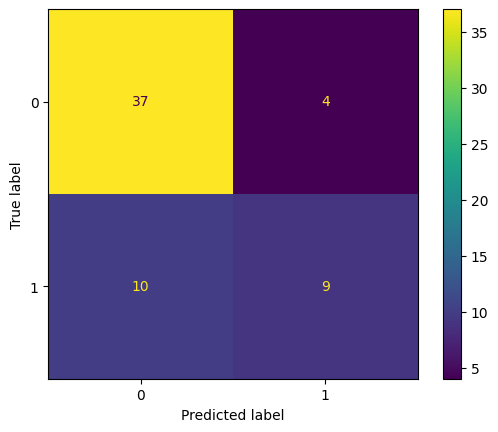

In [30]:
plot_confusion_matrix(cat_boost_classifier.best_estimator_, X_test, y_test)

In [31]:
cat_test_pred = np.where(cat_boost_classifier.predict_proba(X_test)[:,1] > threshold, 1, 0)

cat_score = cat_boost_classifier.score(X_test, y_test)
cat_precision = precision_score(y_test, cat_test_pred)
cat_recall = recall_score(y_test, cat_test_pred)
cat_f1_score = f1_score(y_test, cat_test_pred)
cat_roc_auc = roc_auc_score(y_test, cat_test_pred)

print('Score = {:.5f}'.format(cat_score))
print('Precision = {:.5f}'.format(cat_precision))
print('Recall = {:.5f}'.format(cat_recall))
print('F1 score = {:.5f}'.format(cat_f1_score))
print('AUC = {:.5f}'.format(cat_roc_auc))

Score = 0.76667
Precision = 0.69231
Recall = 0.47368
F1 score = 0.56250
AUC = 0.68806


# Сравнение моделей

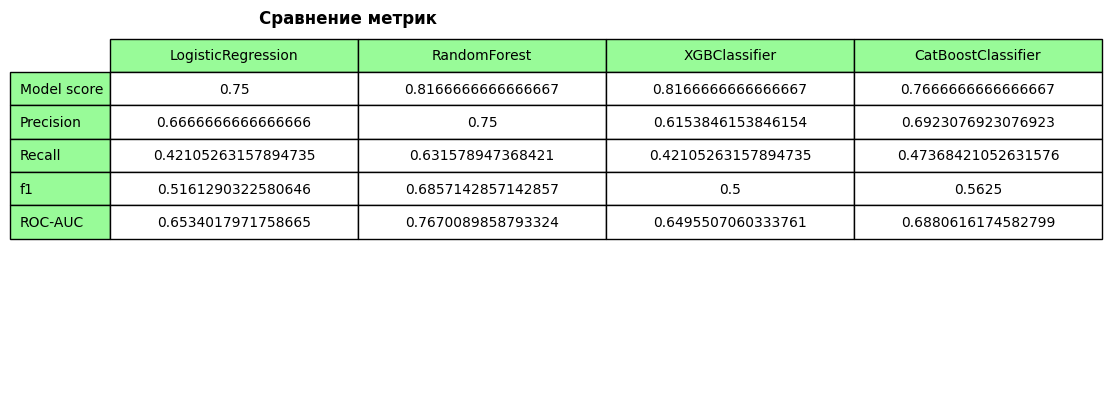

In [65]:
val1 = ["LogisticRegression", "RandomForest", "XGBClassifier", "CatBoostClassifier"] 
val2 = ["Model score", "Precision", "Recall", "f1", "ROC-AUC"] 
val3 = [
    [lr_score, lr_precision, lr_recall, lr_f1_score, lr_roc_auc],
    [rf_score, rf_precision, rf_recall, rf_f1_score, rf_roc_auc],
    [xgb_score, xgb_precision, xgb_recall, xgb_f1_score, xgb_roc_auc],
    [cat_score, cat_precision, cat_recall, cat_f1_score, cat_roc_auc]
]
   
fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table(
    colLabels = val1, 
    rowLabels = val2,  
    cellText = np.array(val3).T,  
    colColours =["palegreen"] * 4,
    rowColours =["palegreen"] * 5,
    cellLoc ='center',  
    loc ='upper left'
)

   
ax.set_title('Сравнение метрик', fontweight ="bold") 
table.scale(2, 2)

plt.show() 

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


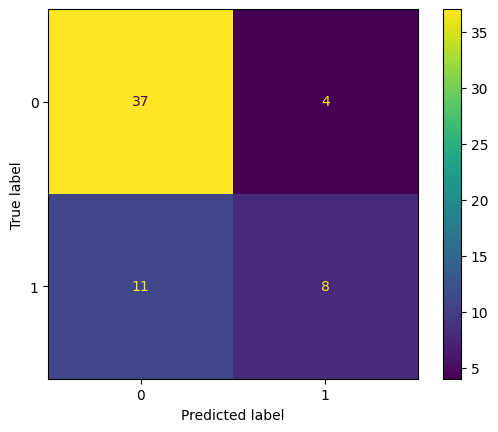

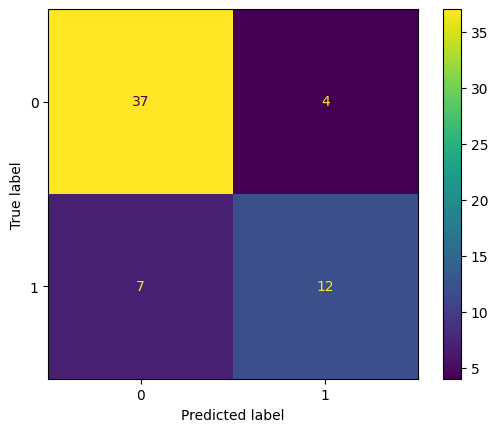

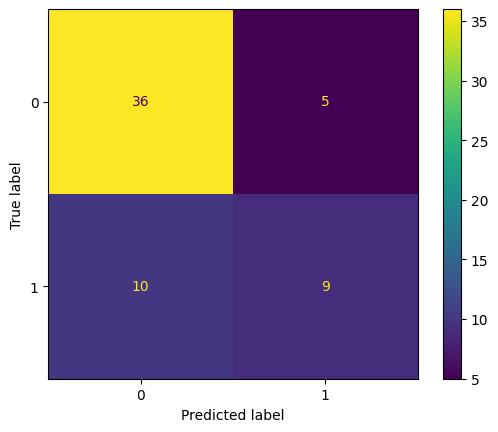

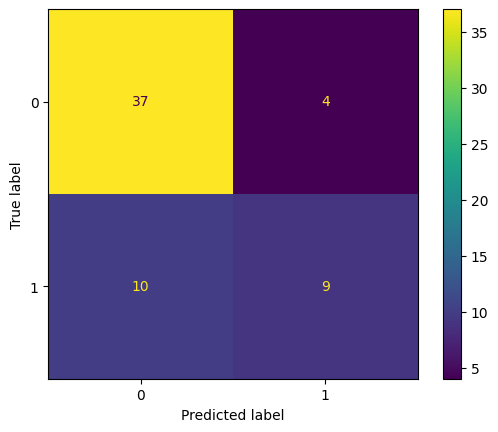

In [66]:
plot_confusion_matrix(logistic_regression.best_estimator_, X_test, y_test)
plot_confusion_matrix(random_forest_classifier.best_estimator_, X_test, y_test)
plot_confusion_matrix(xgb_classifier.best_estimator_, X_test, y_test)
plot_confusion_matrix(cat_boost_classifier.best_estimator_, X_test, y_test)

# Важность признаков

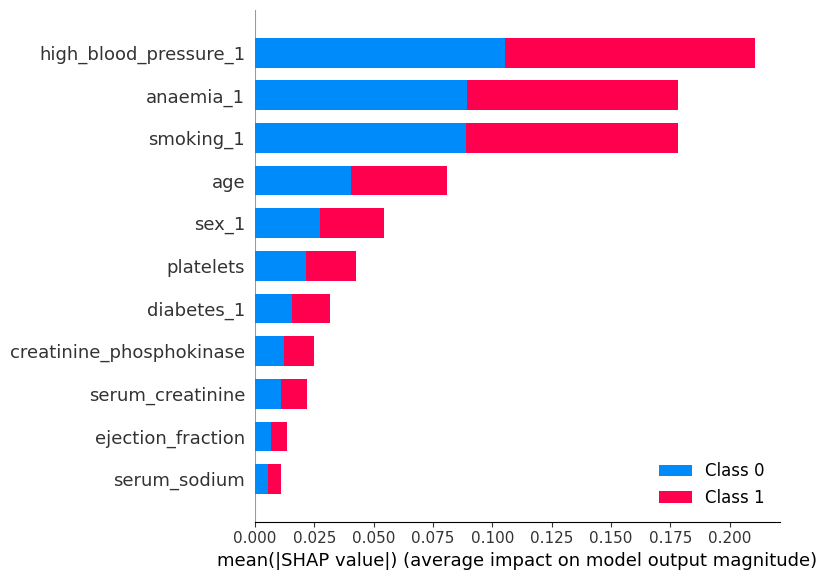

In [46]:
# shap_test = shap.TreeExplainer(xgb_classifier.best_estimator_).shap_values(X_test)
# shap.summary_plot(shap_test, X_test, auto_size_plot=True)
#print(xgb_classifier.best_estimator_.feature_importances_)
df_cat = pd.get_dummies(df[cat_cols], columns=cat_cols, drop_first=True)
feature_names = list(itertools.chain(df_cat.columns, numeric_cols))

shap_values = shap.TreeExplainer(random_forest_classifier.best_estimator_).shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names, max_display=X_test.shape[1], plot_type='bar')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


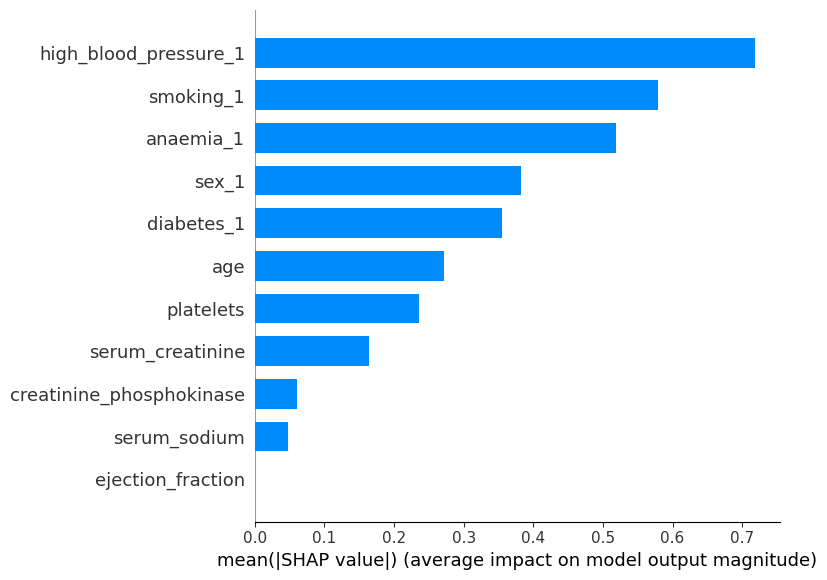

In [47]:
shap_values = shap.TreeExplainer(xgb_classifier.best_estimator_).shap_values(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names, max_display=X_test.shape[1], plot_type='bar')